 <span style="color:#42a5f5; font-size:2em; font-weight:bold;">Modélisation des séries temporelles sur les données d'incidents</span>

Prévision des Incidents des Pompiers de Londres 

L'objectif étant de prédire les interventions futurs des pompiers dans les années à venir afin de mieux organiser leur equipes, leurs materiel, et leur temps d'interventions ...

<span style="color:#e91e63; font-size:1em; font-weight:bold;">1. Import des bibliothèques necessaires</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

# Pour afficher toutes les colonnes
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

<span style="color:#e91e63; font-size:1em; font-weight:bold;">2-Chargement des données et vérifications </span>

In [2]:
# Chargement
processed_file_path = r"..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv"
if not os.path.exists(processed_file_path):
    raise FileNotFoundError(f"Le fichier {processed_file_path} n'existe pas. Veuillez vérifier le chemin.")

print(f"Chargement du fichier : {processed_file_path}")

# Colonnes utiles pour la time series
cols_to_keep = [
    "IncidentNumber", "DateOfCall", "TimeOfCall", "HourOfCall", "IncidentGroup", "IncGeo_BoroughName",
    "NumCalls", "NotionalCost", "PumpCount",
    "NumPumpsAttending", "NumStationsWithPumpsAttending"
]

# Typage strict uniquement sur les colonnes conservées
dtype_map = {
    "IncidentNumber": "string",
    "TimeOfCall": "string",
    "HourOfCall": "Int64",
    "IncidentGroup": "string",
    "IncGeo_BoroughName": "string",
    "NumCalls": "Int64",
    "NotionalCost": "Int64",
    "PumpCount": "Int64",
    "NumPumpsAttending": "Int64",
    "NumStationsWithPumpsAttending": "Int64",
}

Chargement du fichier : ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv


<span style="color:#e91e63; font-size:1em; font-weight:bold;">3-Analyse et vérification des colonnes à mettre en Index date temps </span>

In [3]:
print(" ~~ Début de la Modélisation des Séries Temporelles ~~ ")

#Vérification des datas chargées et leur formatpour la suite:
# Chargement avec conversion explicite
df = pd.read_csv(processed_file_path, usecols=cols_to_keep, dtype=dtype_map, parse_dates=['DateOfCall'], dayfirst=True)
# Vérification du chargement
print(f"- Chargement du fichier {processed_file_path} réussi.")
# Vérification des types de données
print("- Types de données dans le DataFrame :")
print(df.dtypes)
#vérification des valeurs manquantes
print("- Valeurs manquantes par colonne :")
print(df.isnull().sum())
# Vérification des bornes
print(f"Période : de {df['DateOfCall'].min()} à {df['DateOfCall'].max()}")
# Vérifie les types uniques dans ta colonne DateOfCall
print(df['DateOfCall'].apply(type).value_counts())

'''~~~~~~~~~~~~~~~~~~~~'''

# convertir en datetime pour l'indexation: 
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'])
#vérification des datas apres convertion de DateOfCall en datetime pour l'indexation: 
print("-Type de la colonne DateOfCall :", df['DateOfCall'].dtype)
print("-Aperçu des valeurs de DateOfCall :")
display(df[['DateOfCall']].drop_duplicates().head(5))

print("\n-Aperçu des 5 premières lignes du DataFrame :")
display(df.head(5))
print("types de données dans le DataFrame :")
print(df.dtypes)

# Vérification des valeurs manquantes
print("-Valeurs manquantes par colonne :")
print(df.isnull().sum())

print("\n-Statistiques descriptives :")
display(df.describe(include='all'))

print("-Période de la série temporelle :")   
print(f"De: {df['DateOfCall'].min()} au: {df['DateOfCall'].max()}")

 ~~ Début de la Modélisation des Séries Temporelles ~~ 
- Chargement du fichier ..\..\data\raw\Cleaned_data\InUSE\cleaned_data_incidents.csv réussi.
- Types de données dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                               object
TimeOfCall                       string[python]
HourOfCall                                Int64
IncidentGroup                    string[python]
IncGeo_BoroughName               string[python]
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
- Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
N

DateOfCall
0    2009-01-01
405  2009-01-02
709  2009-01-03
1093 2009-01-04
1524 2009-01-05


-Aperçu des 5 premières lignes du DataFrame :


IncidentNumber DateOfCall TimeOfCall  HourOfCall    IncidentGroup  \
0      235138081 2009-01-01   00:00:37           0  Special Service   
1           1091 2009-01-01   00:00:46           0  Special Service   
2           2091 2009-01-01   00:03:00           0             Fire   
3           3091 2009-01-01   00:04:27           0             Fire   
4           5091 2009-01-01   00:05:39           0             Fire   

  IncGeo_BoroughName  NumStationsWithPumpsAttending  NumPumpsAttending  \
0         WANDSWORTH                              2                  2   
1            LAMBETH                           <NA>               <NA>   
2            ENFIELD                              1                  1   
3         HILLINGDON                              1                  1   
4          ISLINGTON                              1                  2   

   PumpCount  NotionalCost  NumCalls  
0          2           255         1  
1          1           255         1  
2          1           255         2  
3          1           255         2  
4          2           255         1

types de données dans le DataFrame :
IncidentNumber                   string[python]
DateOfCall                       datetime64[ns]
TimeOfCall                       string[python]
HourOfCall                                Int64
IncidentGroup                    string[python]
IncGeo_BoroughName               string[python]
NumStationsWithPumpsAttending             Int64
NumPumpsAttending                         Int64
PumpCount                                 Int64
NotionalCost                              Int64
NumCalls                                  Int64
dtype: object
-Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                        

IncidentNumber                     DateOfCall TimeOfCall  HourOfCall  \
count         1824973                        1824973    1824973   1824973.0   
unique        1824973                            NaN      86394        <NA>   
top             21091                            NaN   18:02:06        <NA>   
freq                1                            NaN         56        <NA>   
mean              NaN  2017-03-12 20:50:59.275944960        NaN   13.462605   
min               NaN            2009-01-01 00:00:00        NaN         0.0   
25%               NaN            2012-09-29 00:00:00        NaN         9.0   
50%               NaN            2017-04-15 00:00:00        NaN        14.0   
75%               NaN            2021-09-02 00:00:00        NaN        19.0   
max               NaN            2025-03-31 00:00:00        NaN        23.0   
std               NaN                            NaN        NaN    6.258045   

       IncidentGroup IncGeo_BoroughName  NumStationsWithPumpsAttending  \
count        1824967            1824973                      1810351.0   
unique             3                 33                           <NA>   
top      False Alarm        WESTMINSTER                           <NA>   
freq          894018             133650                           <NA>   
mean             NaN                NaN                       1.370929   
min              NaN                NaN                            1.0   
25%              NaN                NaN                            1.0   
50%              NaN                NaN                            1.0   
75%              NaN                NaN                            2.0   
max              NaN                NaN                           46.0   
std              NaN                NaN                       0.687726   

        NumPumpsAttending  PumpCount  NotionalCost   NumCalls  
count           1810351.0  1824973.0     1824973.0  1823124.0  
unique               <NA>       <NA>          <NA>       <NA>  
top                  <NA>       <NA>          <NA>       <NA>  
freq                 <NA>       <NA>          <NA>       <NA>  
mean             1.555361   1.592914    407.816033   1.327807  
min                   1.0        1.0         255.0        1.0  
25%                   1.0        1.0         290.0        1.0  
50%                   1.0        1.0         328.0        1.0  
75%                   2.0        2.0         364.0        1.0  
max                 106.0      951.0     2277726.0      369.0  
std              0.845371   1.582791   2701.663304   1.487098

-Période de la série temporelle :
De: 2009-01-01 00:00:00 au: 2025-03-31 00:00:00


In [4]:
#vérification des valeurs manquantes
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

# Préprocessing et traitement des valeurs manquantes de la colonne IncidentGroup qui contient 6 valeurs manquantes
# Remplacement des valeurs manquantes dans 'IncidentGroup' par 'False Alarm'
df['IncidentGroup'].fillna('False Alarm', inplace=True)

# Vérification que l'imputation a fonctionné
missing_after = df['IncidentGroup'].isnull().sum()
print(f"Valeurs manquantes restantes dans IncidentGroup : {missing_after}")

# Contrôle de la répartition finale
print("\nRépartition des valeurs dans IncidentGroup après imputation :")
print(df['IncidentGroup'].value_counts())

Valeurs manquantes par colonne :
IncidentNumber                       0
DateOfCall                           0
TimeOfCall                           0
HourOfCall                           0
IncidentGroup                        6
IncGeo_BoroughName                   0
NumStationsWithPumpsAttending    14622
NumPumpsAttending                14622
PumpCount                            0
NotionalCost                         0
NumCalls                          1849
dtype: int64
Valeurs manquantes restantes dans IncidentGroup : 0

Répartition des valeurs dans IncidentGroup après imputation :
IncidentGroup
False Alarm        894024
Special Service    598275
Fire               332674
Name: count, dtype: Int64


In [ ]:
'''#Vérification des données entre le 3 et 31 mars 2025
print("\n- Vérification des données entre le 3 et 31 mars 2025 :")
# Conversion 
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'], dayfirst=True, errors='coerce')

# Sélection des lignes entre 3 mars et 31 mars 2025
mask_march25 = (df['DateOfCall'] >= '2025-03-03') & (df['DateOfCall'] <= '2025-03-31')
df_march25 = df.loc[mask_march25, ['DateOfCall', 'TimeOfCall']]

# VérifiCATION s'il y a des valeurs manquantes dans TimeOfCall
missing_time = df_march25['TimeOfCall'].isna().sum()
total_rows = df_march25.shape[0]

print(f"\nSur {total_rows} lignes entre le 3 et le 31 mars 2025 :")
print(f"- {missing_time} lignes ont TimeOfCall manquant")
print(f"- {total_rows - missing_time} lignes ont un TimeOfCall valide")

# V2RIFIE SIR IL Y A Des lignes manquantes
if missing_time > 0:
    print("\nVoici un aperçu des lignes concernées (DateOfCall sans TimeOfCall) :")
    display(df_march25[df_march25['TimeOfCall'].isna()])'''


- Vérification des données entre le 3 et 31 mars 2025 :

Sur 340 lignes entre le 3 et le 31 mars 2025 :
- 0 lignes ont TimeOfCall manquant
- 340 lignes ont un TimeOfCall valide



<span style="color:#e91e63; font-size:1em; font-weight:bold;">4-Construction de l'Indexation</span>

In [5]:
# Si nécessaire, on trie d'abord les dates
df = df.sort_values('DateOfCall')
#cree la colonne datetemi me à partir de DateOfCall et TimeOfCall
# On crée une colonne DateTime à partir de DateOfCall et TimeOfCall
df['DateTime'] = pd.to_datetime(df['DateOfCall'].astype(str) + ' ' + df['TimeOfCall'], errors='coerce')
# Vérification de la conversion
print("\n- Type de la colonne DateTime :", df['DateTime'].dtype)    


# On crée une colonne dédiée
df['DateOfCall_str'] = df['DateOfCall'].dt.strftime('%Y-%m-%d')

# On fait une copie de la colonne pour l'index (index datetime)
df = df.set_index('DateTime').sort_index()

# Vérification visuelle
print("\nIndexation OK")
print(f"Index DateOfCall : de {df.index.min().date()} à {df.index.max().date()}")
print(f"Nombre de lignes indexées : {df.shape[0]}")

# DateOfCall_str si besoin d'une version lisible
display(df.head())


- Type de la colonne DateTime : datetime64[ns]

Indexation OK
Index DateOfCall : de 2009-01-01 à 2025-03-31
Nombre de lignes indexées : 1824973


IncidentNumber DateOfCall TimeOfCall  HourOfCall  \
DateTime                                                               
2009-01-01 00:00:37      235138081 2009-01-01   00:00:37           0   
2009-01-01 00:00:46           1091 2009-01-01   00:00:46           0   
2009-01-01 00:03:00           2091 2009-01-01   00:03:00           0   
2009-01-01 00:04:27           3091 2009-01-01   00:04:27           0   
2009-01-01 00:05:39           5091 2009-01-01   00:05:39           0   

                       IncidentGroup IncGeo_BoroughName  \
DateTime                                                  
2009-01-01 00:00:37  Special Service         WANDSWORTH   
2009-01-01 00:00:46  Special Service            LAMBETH   
2009-01-01 00:03:00             Fire            ENFIELD   
2009-01-01 00:04:27             Fire         HILLINGDON   
2009-01-01 00:05:39             Fire          ISLINGTON   

                     NumStationsWithPumpsAttending  NumPumpsAttending  \
DateTime                                                                
2009-01-01 00:00:37                              2                  2   
2009-01-01 00:00:46                           <NA>               <NA>   
2009-01-01 00:03:00                              1                  1   
2009-01-01 00:04:27                              1                  1   
2009-01-01 00:05:39                              1                  2   

                     PumpCount  NotionalCost  NumCalls DateOfCall_str  
DateTime                                                               
2009-01-01 00:00:37          2           255         1     2009-01-01  
2009-01-01 00:00:46          1           255         1     2009-01-01  
2009-01-01 00:03:00          1           255         2     2009-01-01  
2009-01-01 00:04:27          1           255         2     2009-01-01  
2009-01-01 00:05:39          2           255         1     2009-01-01

In [ ]:
'''# Vérifie que TimeOfCall est bien une chaîne au format hh:mm:ss
# Si jamais TimeOfCall n'a pas les secondes, on les ajoute artificiellement
df['TimeOfCall'] = df['TimeOfCall'].apply(lambda x: x if len(x.split(':')) == 3 else x + ':00')

# Maintenant, tu peux forcer DateTime proprement
df['DateTime'] = pd.to_datetime(df['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df['TimeOfCall'],errors='coerce')

# Correction claire

# Mets DateTime en index
df.set_index('DateTime', inplace=True)

# Vérification
print("\nIndexation DateTime OK")
print(f"Index DateTime : de {df.index.min()} à {df.index.max()}")
print(f"DateOfCall : de {df['DateOfCall'].min()} à {df['DateOfCall'].max()}")
display(df.describe(include='all'))'''


In [ ]:
'''# vérification : si dans la période du 1er au 31 mars 2025, il reste des valeurs problématiques entre DateOfCall et TimeOfCall qui empêcheraient la création d'une colonne DateTime correcte.
# Vérifie si des lignes sont invalides entre le 3 et 31 mars
df_check = df[(df['DateOfCall'] >= '2025-03-01') & (df['DateOfCall'] <= '2025-03-31')].copy()

# Création  d'une colonne DateTime provisoire
df_check['DateTime_temp'] = pd.to_datetime(
    df_check['DateOfCall'].dt.strftime('%Y-%m-%d') + ' ' + df_check['TimeOfCall'].astype(str),
    errors='coerce'
)

# Montre les lignes posant problème
invalid = df_check[df_check['DateTime_temp'].isna()]
print(f"\nNombre de lignes mal converties entre le 3 et 31 mars : {len(invalid)}")

if not invalid.empty:
    display(invalid[['DateOfCall', 'TimeOfCall']].head(20))'''


<span style="color:#e91e63; font-size:1em; font-weight:bold;">5-Vérifications des appels reçus qui déclenchent les interventions  </span>

Valeurs uniques dans NumCalls :
<IntegerArray>
[  1,   2,   7,   3,  16,   6,   4,   5,  12,  17,
 ...
 103,  60,  58, 124,  80,  82,  71,  99, 127, 210]
Length: 102, dtype: Int64


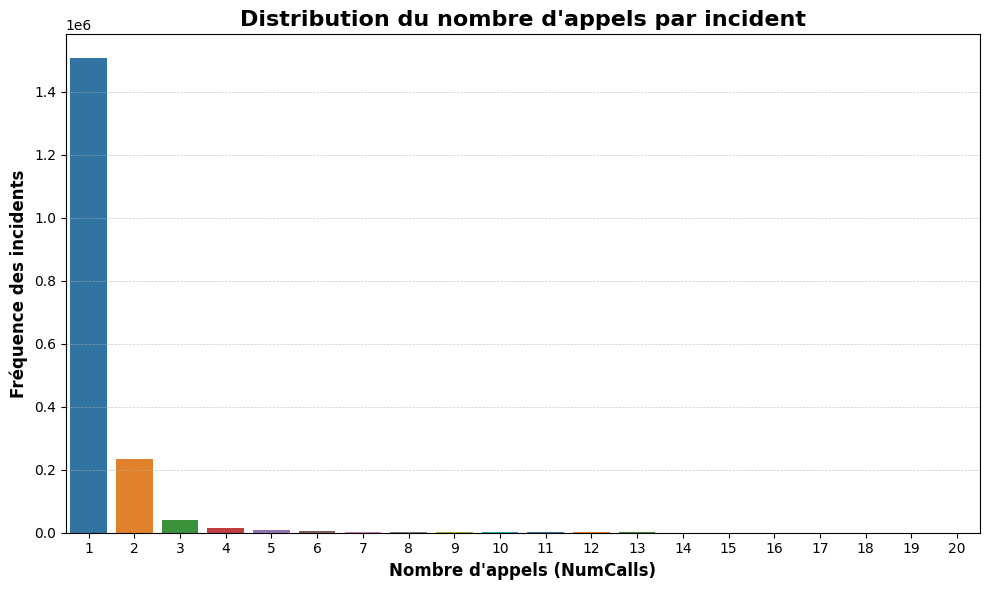

In [6]:
# Analyse de la colonne NumCalls pour determiner les appels pour chaque incident:
# Analyse des valeurs uniques de NumCalls
print("Valeurs uniques dans NumCalls :")
print(df["NumCalls"].unique())

# on réinitialise l’index SANS toucher au df original
num_df = df[df['NumCalls'] <= 20].reset_index(drop=True)

# ordre des barres : du plus fréquent au moins fréquent
order = num_df['NumCalls'].value_counts().index 

# Distribution de NumCalls
plt.figure(figsize=(10, 6))
sns.countplot(data=num_df, x='NumCalls', order=order, palette='tab10')
plt.title("Distribution du nombre d'appels par incident", fontsize=16, fontweight='bold')
plt.xlabel("Nombre d'appels (NumCalls)", fontsize=12, fontweight='bold')
plt.ylabel("Fréquence des incidents", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Environ 90–95 % (visuellement estimé) des incidents ne sont associés qu’à un seul appel !
Cela suggère que pour la plupart des situations, un seul appel suffit à déclencher l’intervention ou à gérer l’incident.

In [7]:
# 1) Lignes où NumCalls est manquant
na_calls = df[df["NumCalls"].isna()]
print(f"Nombre de lignes avec NumCalls manquant : {na_calls.shape[0]}")

# 1-a) Y a-t-il plusieurs enregistrements pour le même IncidentNumber ?
dup_incidents = na_calls.duplicated(subset="IncidentNumber").sum()
print(f"Duplications sur IncidentNumber parmi les NA : {dup_incidents}")

# 1-b) Distribution (rapide) d’autres indicateurs pour comparer aux incidents « normaux »
cols_check = ["NotionalCost", "PumpCount", "NumPumpsAttending", "IncidentGroup", "IncidentNumber", "DateOfCall_str", "IncGeo_BoroughName"]
print("\nRésumé stats des colonnes comparatives :")
display(na_calls[cols_check].describe())

# 1-c) Profil des groupes d’incident
print("\nTop 10 des IncidentGroup pour NA :")
print(na_calls["IncidentGroup"].value_counts().head(10))

Nombre de lignes avec NumCalls manquant : 1849
Duplications sur IncidentNumber parmi les NA : 0

Résumé stats des colonnes comparatives :


NotionalCost  PumpCount  NumPumpsAttending
count        1849.0     1849.0             1793.0
mean       318.4543   1.611141           1.597881
std      530.075481   0.962897           0.778145
min           255.0        1.0                1.0
25%           260.0        1.0                1.0
50%           260.0        1.0                1.0
75%           290.0        2.0                2.0
max         14234.0       16.0                6.0


Top 10 des IncidentGroup pour NA :
IncidentGroup
False Alarm        1319
Fire                327
Special Service     203
Name: count, dtype: Int64


Pas de doublons sur IncidentNumber, Chaque ligne est un incident unique car pas de doublons	
PumpCount ≥ 1 (min = 1, mean ≈ 1,6)	Au moins un engin s’est déplacé → il y a eu  donc un vrai appel !	
NotionalCost ≥ 255 £ (coût > 0 pour toutes)	Un coût est logiquement généré seulement si l’appel est valide !
IncidentGroup majoritairement “False Alarm” (71 %)	Même pour une fausse alerte, il faut au moins un appel pour déclencher l’intervention

Décision: ==>Imputation des NA en 1 

In [8]:
# Traitement des valeurs manquantes dans NumCalls
# 1. Identifier les lignes avec NumCalls manquant:
numcalls_na = df["NumCalls"].isna()

# 2. Déterminer si l'incident montre une vraie intervention (coût ou engin mobilisé):
intervention_probable = (
    (df["PumpCount"] > 0) |
    (df["NumPumpsAttending"] > 0) |
    (df["NotionalCost"] > 0)
)

# 3. Imputer 1 appel si une intervention est probable:
df.loc[numcalls_na & intervention_probable, "NumCalls"] = 1

# 4. Pour les rares cas restants, imputer 0:
df["NumCalls"].fillna(0, inplace=True)

# 5. Vérification:

print("\nDistribution finale des valeurs de NumCalls :")
print(df["NumCalls"].value_counts(dropna=False).sort_index())
# Nombre total de lignes dans NumCalls
nb_lignes_numcalls = df["NumCalls"].shape[0]
print(f"Nombre total de lignes dans NumCalls : {nb_lignes_numcalls}")

# Vérifie qu'il n'y a plus de NA
print("\nValeurs manquantes dans apres imputation NumCalls :")
print(df["NumCalls"].isna().sum())

# Résumé statistique
print("\nStatistiques descriptives de NumCalls :")
print(df["NumCalls"].describe())


Distribution finale des valeurs de NumCalls :
NumCalls
1      1509185
2       233663
3        39154
4        13688
5         7635
        ...   
144          1
161          1
175          1
210          1
369          1
Name: count, Length: 101, dtype: Int64
Nombre total de lignes dans NumCalls : 1824973

Valeurs manquantes dans apres imputation NumCalls :
0

Statistiques descriptives de NumCalls :
count    1824973.0
mean      1.327474
std       1.486381
min            1.0
25%            1.0
50%            1.0
75%            1.0
max          369.0
Name: NumCalls, dtype: Float64


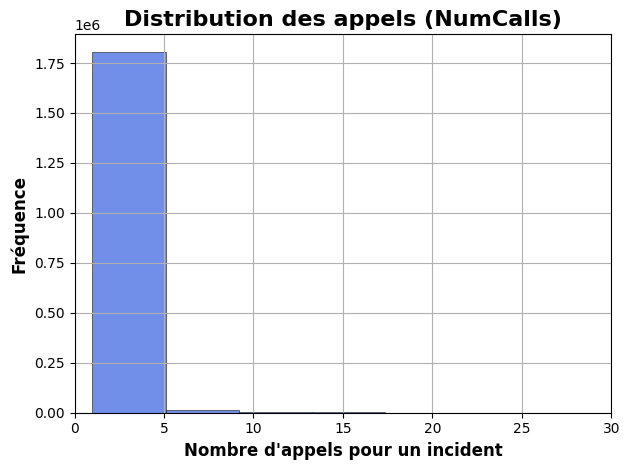

In [9]:
# Histogramme centré sur les valeurs les plus courantes des appels
sns.histplot(df["NumCalls"], bins=90, color="royalblue")
plt.xlim(0, 30)  
plt.title("Distribution des appels (NumCalls)", fontsize=16, fontweight='bold')
plt.xlabel("Nombre d'appels pour un incident", fontsize=12, fontweight='bold')
plt.ylabel("Fréquence", fontsize=12, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

Distribution très déséquilibrée:
La quasi-totalité des incidents sont associés à très peu d'appels (typiquement entre 1 et 5)


- Etude de appels par différentes dimensions
 taille: Hourly : (142416, 15) | Daily : (5934, 15) | Weekly : (849, 15) | Monthly : (195, 15) | Yearly : (17, 15)


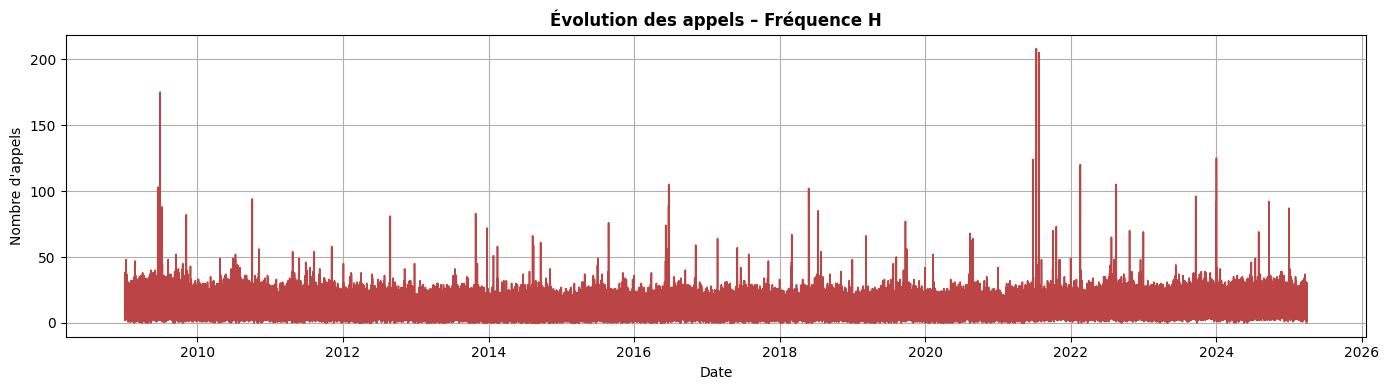

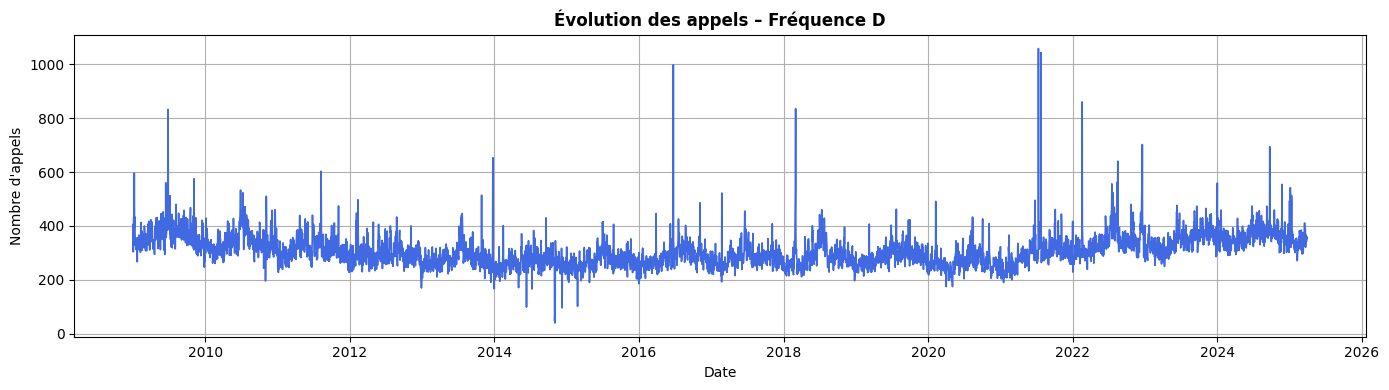

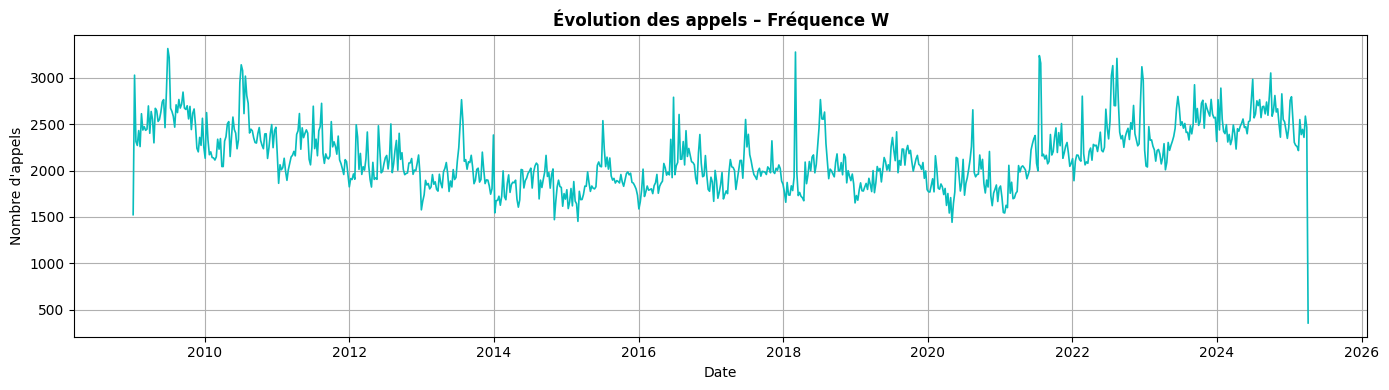

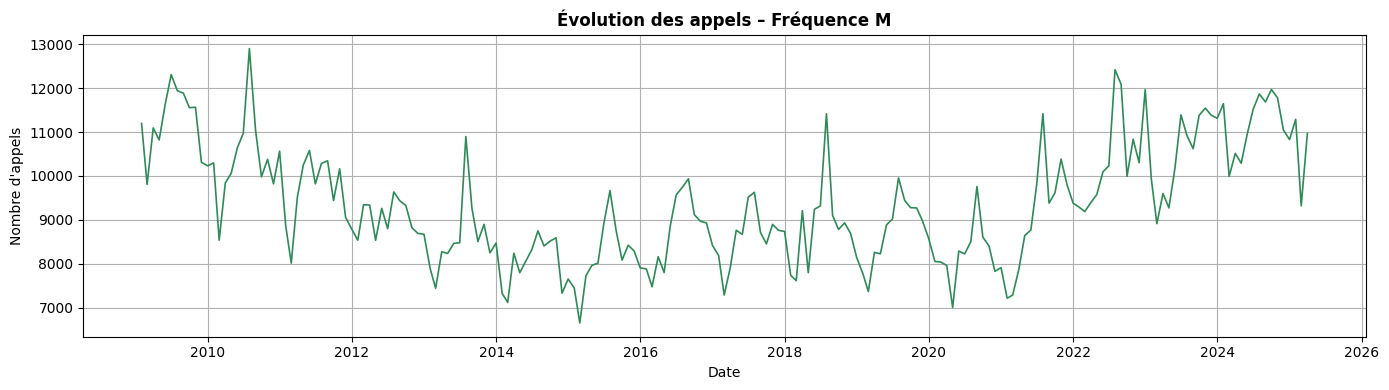

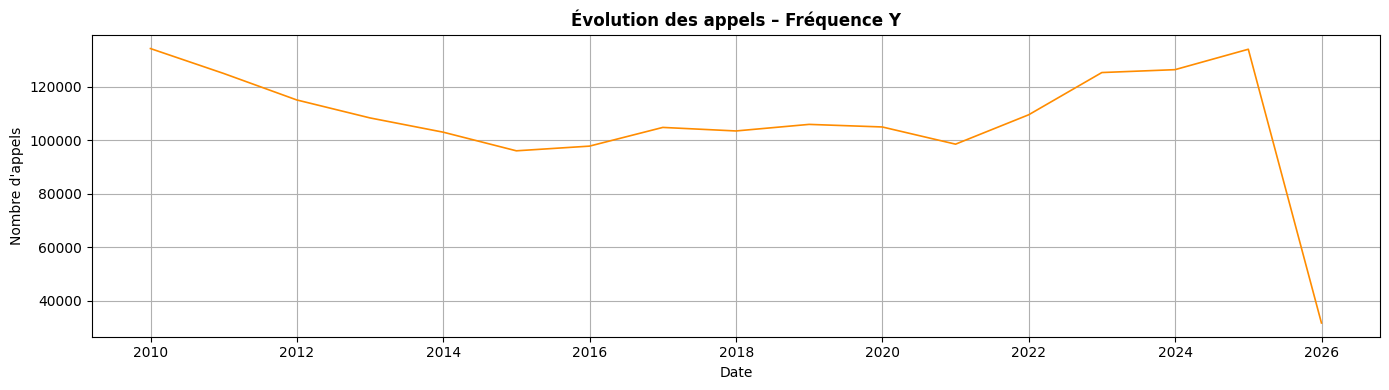

weekday  hour  NumCalls_count  NumCalls_sum  NumCalls_mean  \
0        0     0            7719         11166        1.44656   
1        0     1            6447          9419        1.46099   
2        0     2            5238          7772       1.483772   
3        0     3            4474          6533       1.460215   
4        0     4            4063          5463       1.344573   

   NotionalCost_count  NotionalCost_sum  NotionalCost_mean  PumpCount_count  \
0                7719           3155218         408.759943             7719   
1                6447           2917203         452.489995             6447   
2                5238           2791527         532.937572             5238   
3                4474           1976614         441.800179             4474   
4                4063           1820540         448.077775             4063   

   PumpCount_sum  PumpCount_mean  NumPumpsAttending_count  \
0          12483        1.617178                     7665   
1          10462         1.62277                     6380   
2           8805        1.680985                     5152   
3           7305        1.632767                     4374   
4           6713        1.652227                     3998   

   NumPumpsAttending_sum  NumPumpsAttending_mean  \
0                  12072                1.574951   
1                   9985                1.565047   
2                   8225                1.596467   
3                   6970                1.593507   
4                   6375                1.594547   

   NumStationsWithPumpsAttending_count  NumStationsWithPumpsAttending_sum  \
0                                 7665                              10425   
1                                 6380                               8584   
2                                 5152                               7045   
3                                 4374                               6003   
4                                 3998                               5496   

   NumStationsWithPumpsAttending_mean  
0                            1.360078  
1                            1.345455  
2                             1.36743  
3                            1.372428  
4                            1.374687

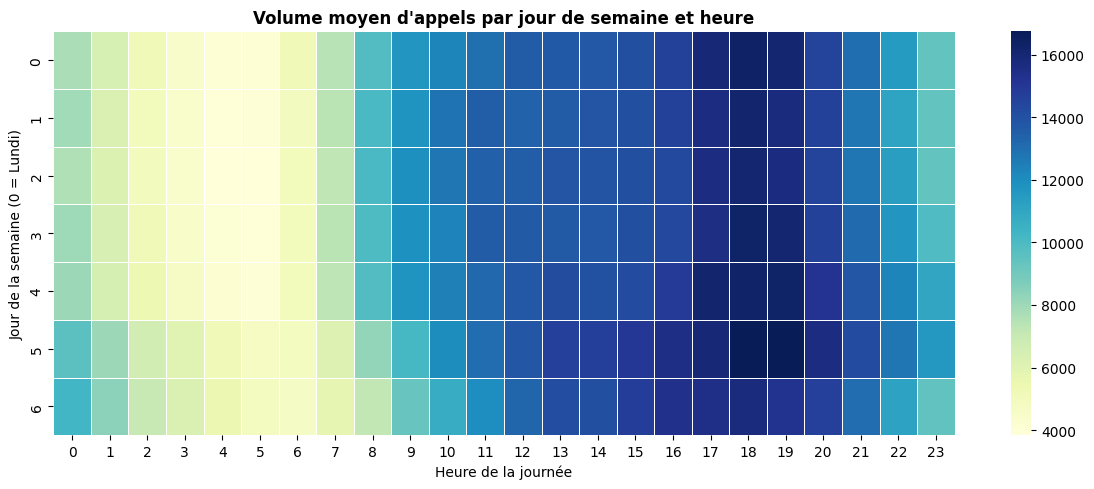

In [10]:
# Etude de appels par differentes dimensions
print("\n- Etude de appels par différentes dimensions")
# Enrichissement calendaire
df = df.assign(
    year=df.index.year,
    quarter=df.index.quarter,
    month=df.index.month,
    week=df.index.isocalendar().week,
    weekday=df.index.dayofweek,  # 0 = lundi
    day=df.index.day,
    hour=df.index.hour
).astype({
    "year": "Int64", "quarter": "Int64", "month": "Int64", "week": "Int64",
    "weekday": "Int64", "day": "Int64", "hour": "Int64"
})

# Fonctions d'agrégation
NUM_COLS = ["NumCalls", "NotionalCost", "PumpCount", "NumPumpsAttending", "NumStationsWithPumpsAttending"]
DEFAULT_FUNCS = ["count", "sum", "mean"]

def aggregate_by_time(freq="D", columns=NUM_COLS, funcs=DEFAULT_FUNCS):
    """ Agrège les colonnes numériques par fréquence temporelle """
    agg_map = {col: funcs for col in columns}
    df_ts = df.resample(freq).agg(agg_map)
    df_ts.columns = [f"{col}_{func}" for col, func in df_ts.columns.to_flat_index()]
    return df_ts


def aggregate_by_dimensions(dims=("weekday", "hour"), columns=NUM_COLS, funcs=DEFAULT_FUNCS, dropna=True):
    """ Cube multi-index pour analyses croisées temporelles """
    agg_map = {col: funcs for col in columns}
    df_cube = df.groupby(list(dims)).agg(agg_map).reset_index()
    df_cube.columns = ["_".join(map(str, col)).strip("_") for col in df_cube.columns]
    return df_cube.dropna(how="all", axis=1) if dropna else df_cube

# Fonction de visualisation
def plot_timeseries(data, freq_label, color, y_col="NumCalls_count"):
    plt.figure(figsize=(14, 4))
    plt.plot(data.index, data[y_col], color=color, linewidth=1.2)
    plt.title(f"Évolution des appels – Fréquence {freq_label}", fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'appels")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Agrégations temporelles
df_hourly  = aggregate_by_time("H")
df_daily   = aggregate_by_time("D")
df_weekly  = aggregate_by_time("W")
df_monthly = aggregate_by_time("M")
df_yearly  = aggregate_by_time("Y")

print(" taille: Hourly :", df_hourly.shape, "| Daily :", df_daily.shape, "| Weekly :", df_weekly.shape, "| Monthly :", df_monthly.shape, "| Yearly :", df_yearly.shape)

# Visualisation des séries temporelles=
COLOR_MAP = {"H": "#BB4545", "D": "royalblue", "W": "#08bdbd", "M": "seagreen", "Y": "darkorange"}

for label, data in [("H", df_hourly), ("D", df_daily), ("W", df_weekly), ("M", df_monthly), ("Y", df_yearly)]:
    plot_timeseries(data, label, COLOR_MAP[label])

# Cube Jour de Semaine x Heure
cube_weekday_hour = aggregate_by_dimensions(("weekday", "hour"))
display(cube_weekday_hour.head())

#Heatmap par heure et jour de semaine
heatmap_data = cube_weekday_hour.pivot(index="weekday", columns="hour", values="NumCalls_count").fillna(0)

plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data.astype(float), cmap="YlGnBu", linewidths=0.5)
plt.title("Volume moyen d'appels par jour de semaine et heure", fontweight="bold")
plt.xlabel("Heure de la journée")
plt.ylabel("Jour de la semaine (0 = Lundi)")
plt.tight_layout()
plt.show()

Observation sur les differentes granularité d'évolution des appels:

Plus on s’éloignes dans le temps (H → D → W → M→Y), plus on gagnes en lisibilité de la tendance :   
-"Evolution des appels-Fréquence H" => À l’heure : bruit, événements extrêmes
-"Evolution des appels-Fréquence D" => Au jour : stabilisation avec pics visibles
-"Evolution des appels-Fréquence W" => À la semaine : cycles lissés
-"Evolution des appels-Fréquence M" => Au mois : tendance globale, saisonnalité très lisible
-"Évolution des appels – Fréquence Annuelle Y" => à l'année: 
2009-2015 : Déclin net du nombre d'appels, avec une perte d’environ 25% du volume initial.
2016-2020 : Phase de stabilisation entre 95k et 105k appels/an, avec de petites fluctuations sans tendance claire.
2021-2024 : Reprise forte et continue, le nombre d'appels repart à la hausse et dépasse le niveau de 2009.
2025 (partiel) : Chute brutale uniquement due au fait que les données s'arrêtent au 31 mars 2025. Cette baisse n’a rien d’opérationnel, elle est due à l’absence de données complètes.

La granularité hebdo ou mensuelle/annuelle semble la plus pertinente pour anticiper la charge.

Synthèse de la Heatmap:
Volume moyen d'appels par jour de la semaine et heure
Ce qu’on observe :
Les appels sont surtout concentrés en journée, entre 8h et 20h. C’est vraiment en fin d’après-midi, entre 16h30 et 19h, que l’on constate le plus gros pic d’activité! Mardi etant le jour avec le plus grand nombre d'appels independament de l'heure d'appel
La répartition est plutôt stable du lundi au dimanche

| Période    | Volume d’appels | Commentaire                         |
| ---------- | --------------- | ----------------------------------- |
| 2009-2014  | En baisse       | Réduction progressive d’activité    |
| 2015-2020  | Stable          | Activité consolidée                 |
| 2021-2024  | En hausse       | Reprise importante                  |
| Après 2024 | Forte chute     | 3 mois de datas 2025 insuffisant    |
|            |                 | pour observé une tendence annuelle  |

<span style="color:#e91e63; font-size:1em; font-weight:bold;">6- Analyse de la répartition et évolution des incidents: jour, mois, heure, année   </span>

In [11]:
#vérification de l'index:
df["DateTime"] = df.index
print("Type d'index :", type(df.index))
print("Nom de l'index :", df.index.name)

Type d'index : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Nom de l'index : DateTime



Shapes des séries :
Hourly : (142416,)
Daily  : (5934,)
Weekly : (849,)
Monthly: (195,)
Yearly : (17,)


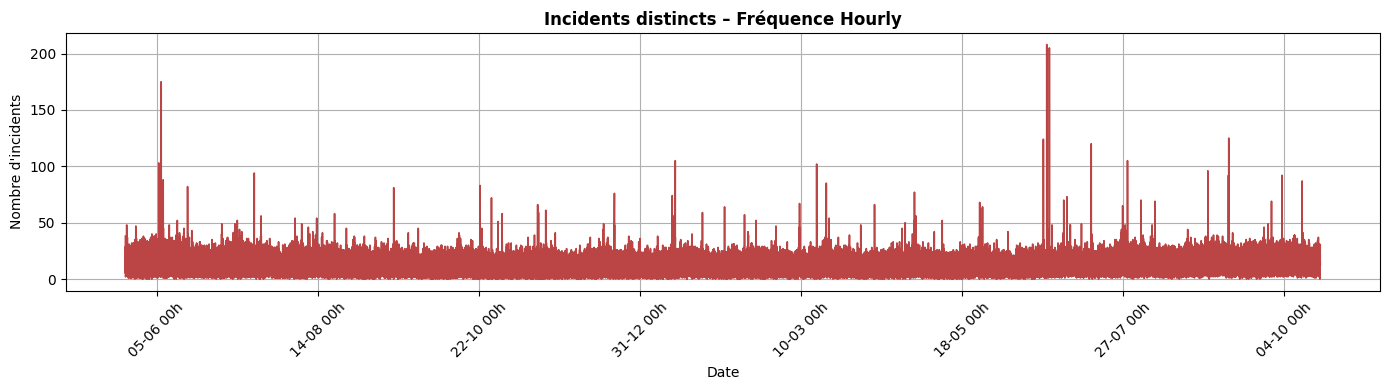

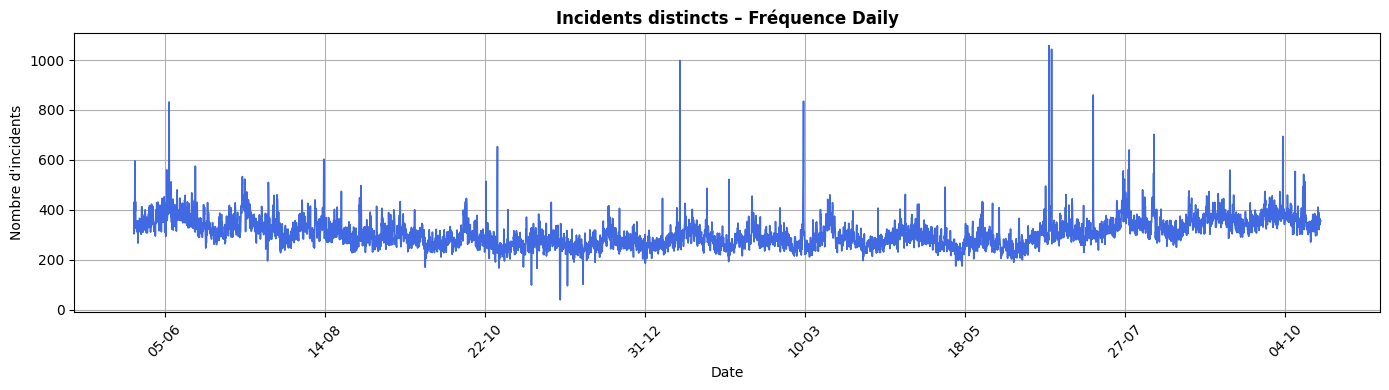

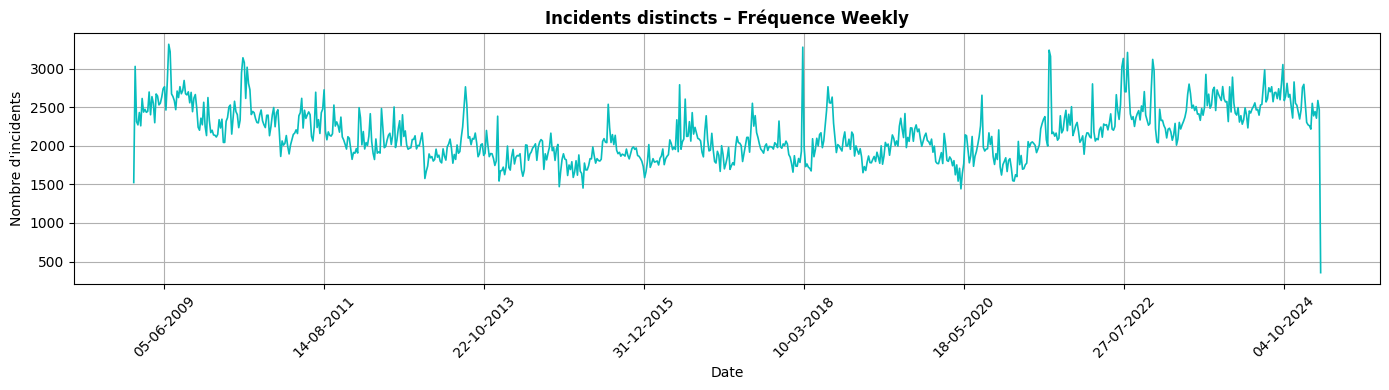

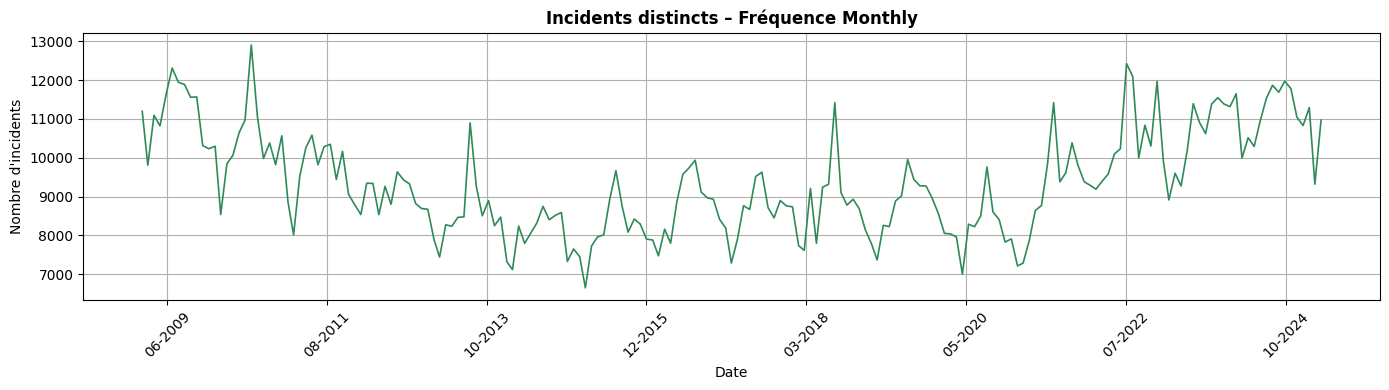

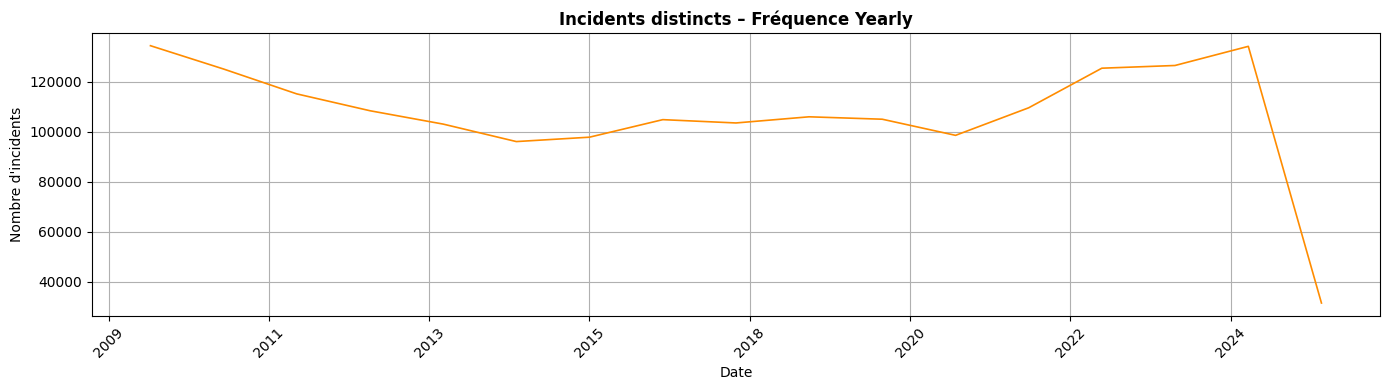

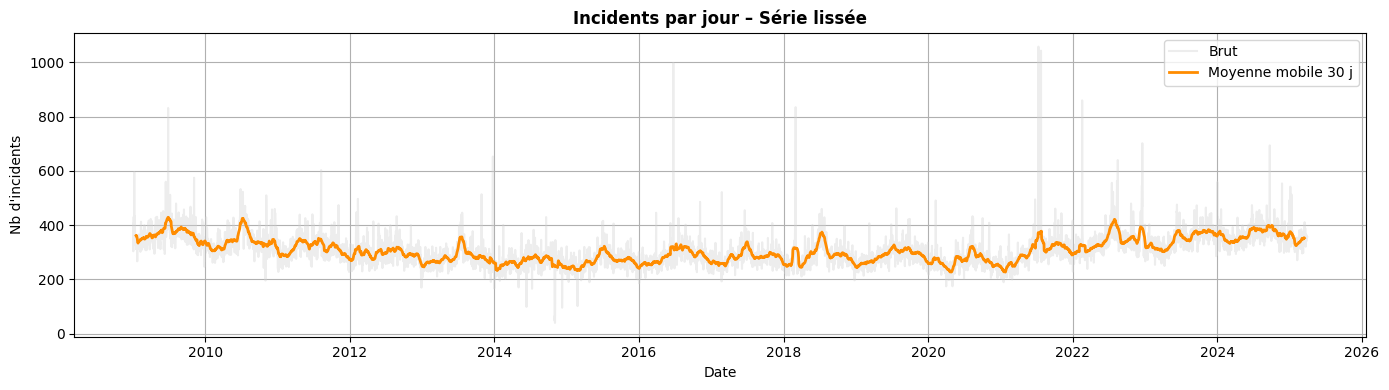

In [12]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# 1️ Fonction d'agrégation unique
def incidents_ts(df, freq="D"):
    return df.resample(freq)["IncidentNumber"].nunique().rename("incident_count")

# 2 Séries par fréquence
frequencies = {
    "Hourly": "H",
    "Daily": "D",
    "Weekly": "W",
    "Monthly": "M",
    "Yearly": "Y"
}
series_dict = {label: incidents_ts(df, freq) for label, freq in frequencies.items()}

# Vérification des tailles
print("\nShapes des séries :")
for label, serie in series_dict.items():
    print(f"{label:<7}: {serie.shape}")

# 3️ Visualisations homogènes
COLOR = {
    "Hourly": "#BB4545",
    "Daily": "royalblue",
    "Weekly": "#08bdbd",
    "Monthly": "seagreen",
    "Yearly": "darkorange"
}

date_format = {
    "Hourly": mdates.DateFormatter('%d-%m %Hh'),
    "Daily": mdates.DateFormatter('%d-%m'),
    "Weekly": mdates.DateFormatter('%d-%m-%Y'),
    "Monthly": mdates.DateFormatter('%m-%Y'),
    "Yearly": mdates.DateFormatter('%Y')
}

for label, serie in series_dict.items():
    plt.figure(figsize=(14, 4))
    plt.plot(serie.index, serie, color=COLOR[label], linewidth=1.2)
    plt.title(f"Incidents distincts – Fréquence {label}", fontweight="bold")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'incidents")
    plt.grid(True)

    ax = plt.gca()
    ax.xaxis.set_major_formatter(date_format[label])
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4️ Lissage mobile (version plus claire)
window = 30
inc_daily = series_dict["Daily"]
inc_daily_smooth = inc_daily.rolling(window=window, center=True).mean()

plt.figure(figsize=(14, 4))
plt.plot(inc_daily, color="lightgrey", alpha=0.4, label="Brut")
plt.plot(inc_daily_smooth, color="darkorange", linewidth=2, label=f"Moyenne mobile {window} j")
plt.title("Incidents par jour – Série lissée", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Nb d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Observation:
Horaire (H)	Très granulaire. Des pics exceptionnels (vers 2022).
Journalier (D)	Densité très forte, très bonne base pour analyse saisonnière.
Hebdo (W)	Les cycles plus larges sont visibles ; utile pour détecter baisses structurelles.
Mensuel (M)	Super clair : on voit un effondrement des données en 2024–2025 car les données s'arrettent au 31/03/2025.


##  **Conclusion :**
* Les courbes liées a `IncidentNumber` et `NumCalls` montrent la **même dynamique à toutes les fréquences**.
* On peux **choisir l’une ou l’autre colonne pour la modélisation** selon l'objectif :

  * **NumCalls** : Volume d’appels, plus lisible métier.
  * **IncidentNumber** : Compte distinct des évènements.

**Les deux variables sont bien corrélées.**

 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 7- Décomposition saisonnières ( additive/multiplicative) </span>

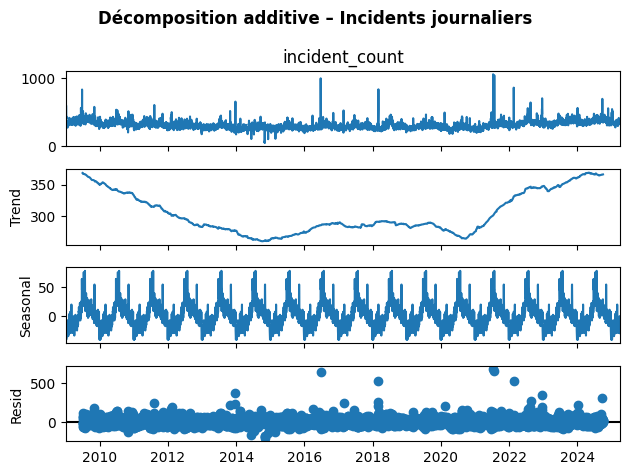

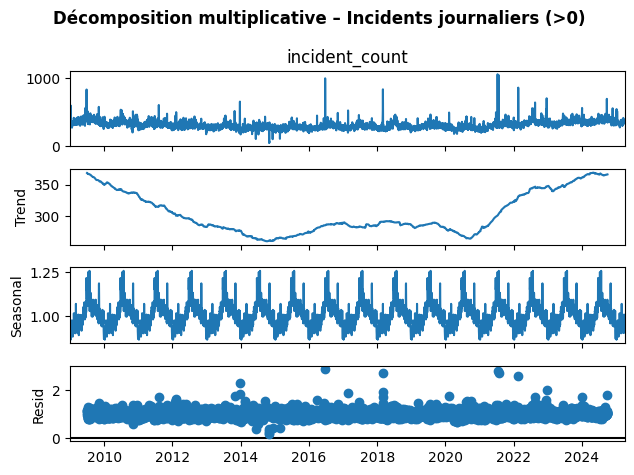

In [13]:
# 5. Décompositions saisonnières
from statsmodels.tsa.seasonal import seasonal_decompose

# a) Additive
decomp = seasonal_decompose(inc_daily, model="additive", period=365)
decomp.plot()
plt.suptitle("Décomposition additive – Incidents journaliers", fontweight="bold")
plt.tight_layout()
plt.show()

# b) Multiplicative
inc_daily_nonzero = inc_daily[inc_daily > 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)
decomp_mult.plot()
plt.suptitle("Décomposition multiplicative – Incidents journaliers (>0)", fontweight="bold")
plt.tight_layout()
plt.show()

## **Décomposition Additive : Incidents Journaliers**

### Ce que l'on remarque :

* **Tendance (Trend)** : Elle montre une baisse progressive des incidents entre 2010 et 2015, suivie d'une lente remontée jusqu'à 2024. C'est très lisible.
* **Saisonnalité (Seasonal)** : Elle est fixe dans l'additif : la même amplitude est conservée tout au long de la série. Cela signifie que le modèle suppose que les variations saisonnières (pics et creux) sont constantes dans le temps, quelles que soient les évolutions de la tendance.
* **Résidus (Resid)** : On voit des points atypiques (outliers) assez marqués, surtout vers la fin. Cela signifie que certains jours ont des valeurs très éloignées de ce qu’expliquerait la tendance et la saisonnalité seule.

### En résumé :

La décomposition **additive** est adaptée quand l'effet saisonnier est supposé constant au fil des ans. On voit des fluctuations d'ampleur similaire même quand la tendance change.


## **Décomposition Multiplicative : Incidents Journaliers (>0)**

### Ce que l'on remarque :

* **Tendance (Trend)** : Elle suit le même schéma général que l'additive, mais avec des valeurs transformées (plus proches de proportions ou rapports que de quantités brutes).
* **Saisonnalité (Seasonal)** : Ici, elle est relative : on voit qu'elle oscille autour de 1 (pas autour d'une valeur fixe) et son effet est proportionnel au niveau de la tendance. Quand la tendance est basse, l'effet saisonnier est faible, et inversement.
* **Résidus (Resid)** : Ils semblent plus homogènes, ce qui est normal car les effets disproportionnés sont "absorbés" par la multiplicativité. Mais des jours atypiques subsistent.

### En résumé :

La décomposition **multiplicative** suppose que les effets saisonniers sont proportionnels au niveau général des incidents. On voit ici que c’est plus pertinent dans les périodes où le volume change fortement : l’amplitude saisonnière est réduite quand l’activité est faible, et amplifiée quand elle est forte.



## **Comparaison générale:**

|                         | **Additive**                   | **Multiplicative**           |
| ----------------------- | ------------------------------ | ---------------------------- |
| **Saisonnalité**        | Constante                      | Proportionnelle au niveau    |
| **Lecture des résidus** | Résidus parfois très dispersés | Résidus plus homogènes       |
| **À privilégier si...** | Effets saisonniers fixes       | Effets saisonniers évolutifs |

---

## **Décision pour la suite :**

Pour **comparer des tendances de fond sur de longues périodes**, l'additif est plus facile à interpréter.
Pour **modéliser des séries où les variations saisonnières varient avec le volume**, la multiplicative est plus pertinente.

Dans ce cas, vu les fortes différences d’activité (2014, 2017, 2023...), **la multiplicative semble plus robuste** car elle s’adapte mieux aux changements de niveau d’activité.

Nous avons décidé de pousser plus loin avec une STL qui combine les avantages des deux décompostion.


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 8- Test de saisonnalité et autocorrelation  ( additive/multiplicative) </span>

In [14]:
#  6. Test de stationnarité (ADF):  
def adf_test(series):
    """ Faire le test de Dickey-Fuller augmenté (ADF) pour vérifier la stationnarité."""
    result = adfuller(series)
    p_value = result[1]
    is_stationary = p_value < 0.05
    return p_value, is_stationary
# Test sur la série journalière
p_value, is_stationary = adf_test(inc_daily)
print(f"Test ADF sur la série journalière : p-value = {p_value:.4f}, la série est-elle bien stationnaire ? {is_stationary}")


#  7. Autocorrélation et autocorrélation partielle:
def plot_acf_pacf(series, lags=50):
    """ Afficher les graphiques ACF et PACF"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(series, lags=lags, ax=ax[0], title="ACF (Autocorrélation)")
    plot_pacf(series, lags=lags, ax=ax[1], title="PACF (Autocorrélation partielle)")
    plt.tight_layout()
    plt.show()

Test ADF sur la série journalière : p-value = 0.0003, la série est-elle bien stationnaire ? True


In [15]:
print("Dernière date de données :", df["DateOfCall"].max())

Dernière date de données : 2025-03-31 00:00:00


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 9-Décomposition STL</span>

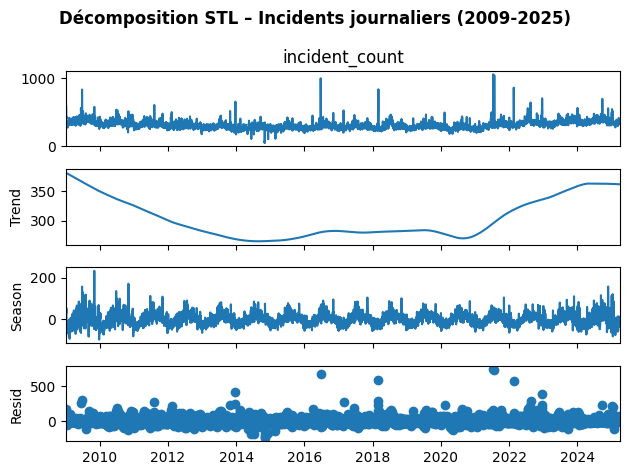

In [16]:
from statsmodels.tsa.seasonal import STL

# On recrée la série quotidienne propre à partir du DataFrame indexé
# Ici on suppose que 'IncidentNumber' est bien en index 'DateOfCall' déjà et que la colonne IncidentNumber est propre
inc_daily = df.resample('D')["IncidentNumber"].nunique().rename("incident_count")

# Application de la STL
stl = STL(inc_daily, period=365, robust=True)
res_stl = stl.fit()

# Visualisation
fig = res_stl.plot()
fig.suptitle("Décomposition STL – Incidents journaliers (2009-2025)", weight='bold')
plt.tight_layout()
plt.show()

Observation sur la décomposition STL :
Cette décomposition STL est bien plus souple que les précédentes.
On remarque que :

La tendance est lissée proprement, et suit bien l’évolution globale sur 2009-2025, avec une baisse puis une lente remontée.

La saisonnalité est plus réaliste ici : elle varie en intensité et n’est pas figée. Cependant, on voit qu’elle capte des irrégularités plus violentes (pics positifs et négatifs importants), probablement des événements exceptionnels dans la série ( covid, ...).

Les résidus sont plus propres et plus centrés, mais il reste des jours très atypiques.

** En résumé:**
La STL fait un meilleur travail pour détecter la vraie tendance et les irrégularités cachées, surtout sur une série aussi instable et longue. Mais elle confirme que la série reste très bruitée.

  <span style="color:royalblue; font-size:1em; font-weight:bold;"> Comparatif des 3 décompositions: </span>

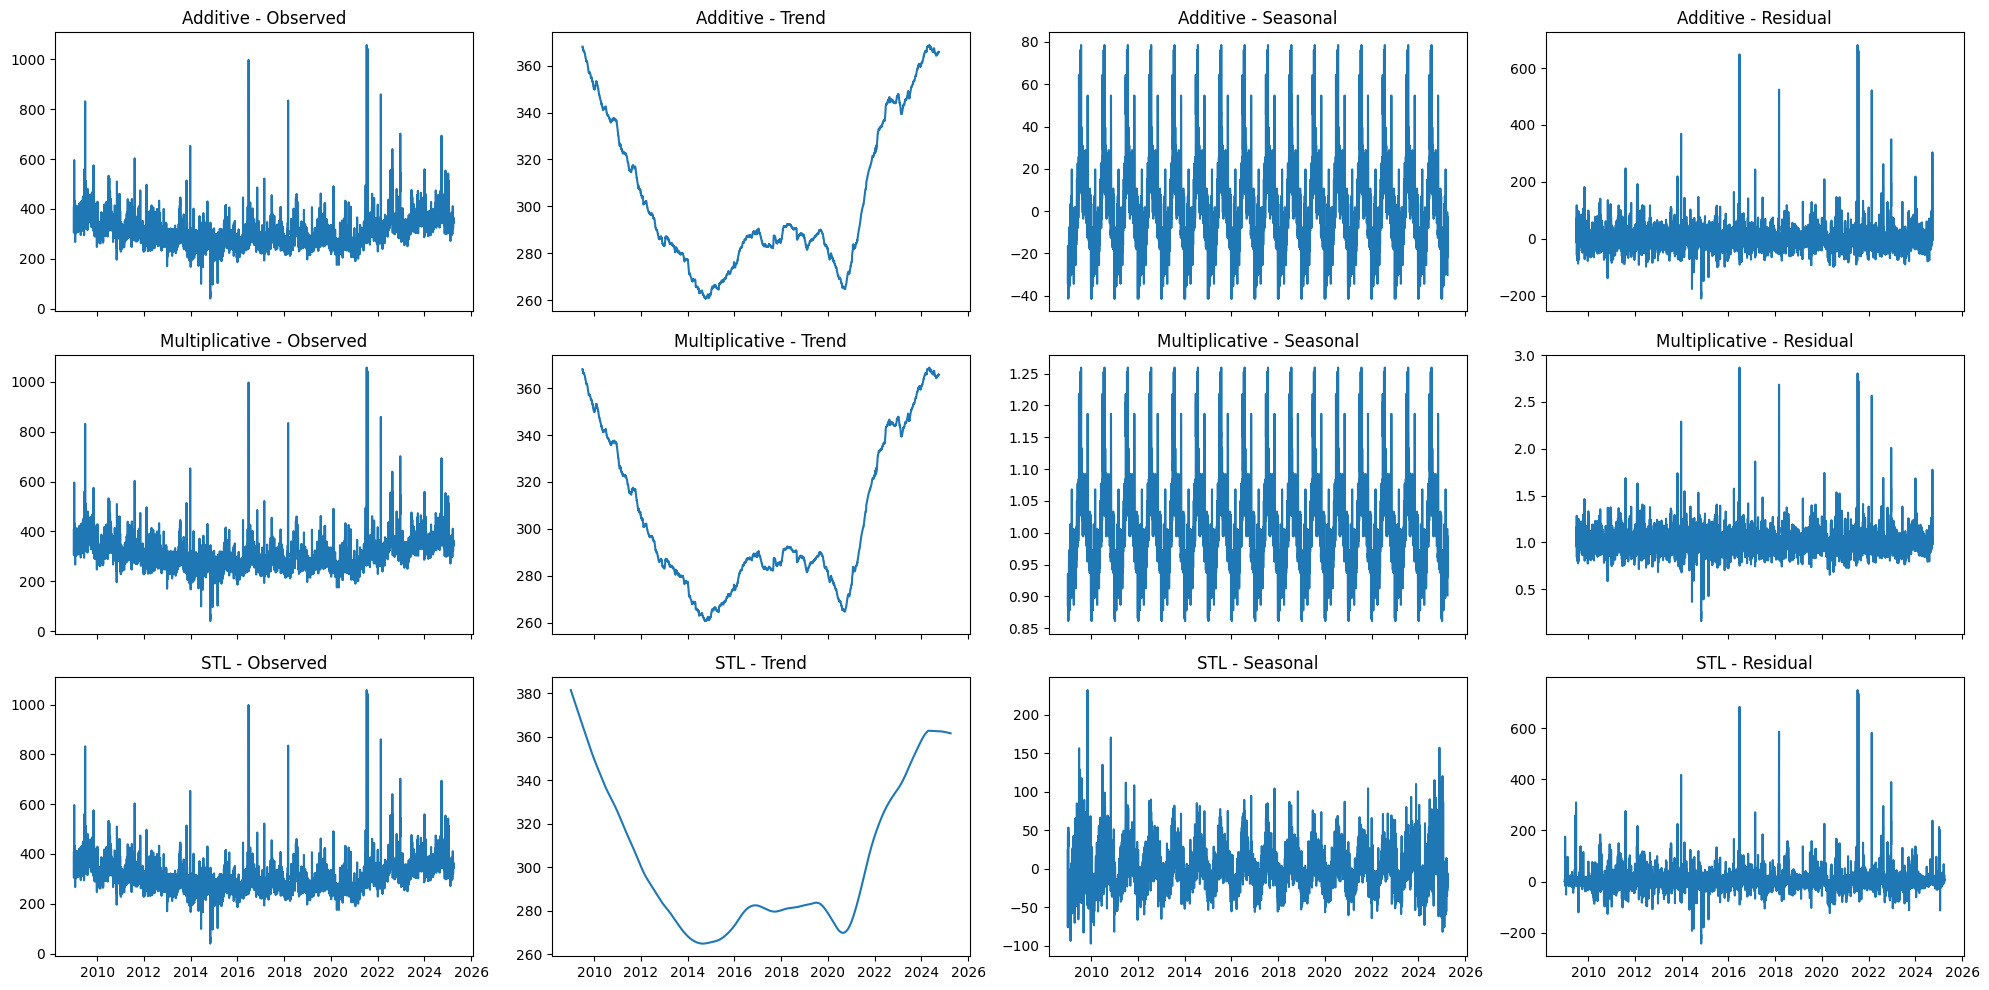

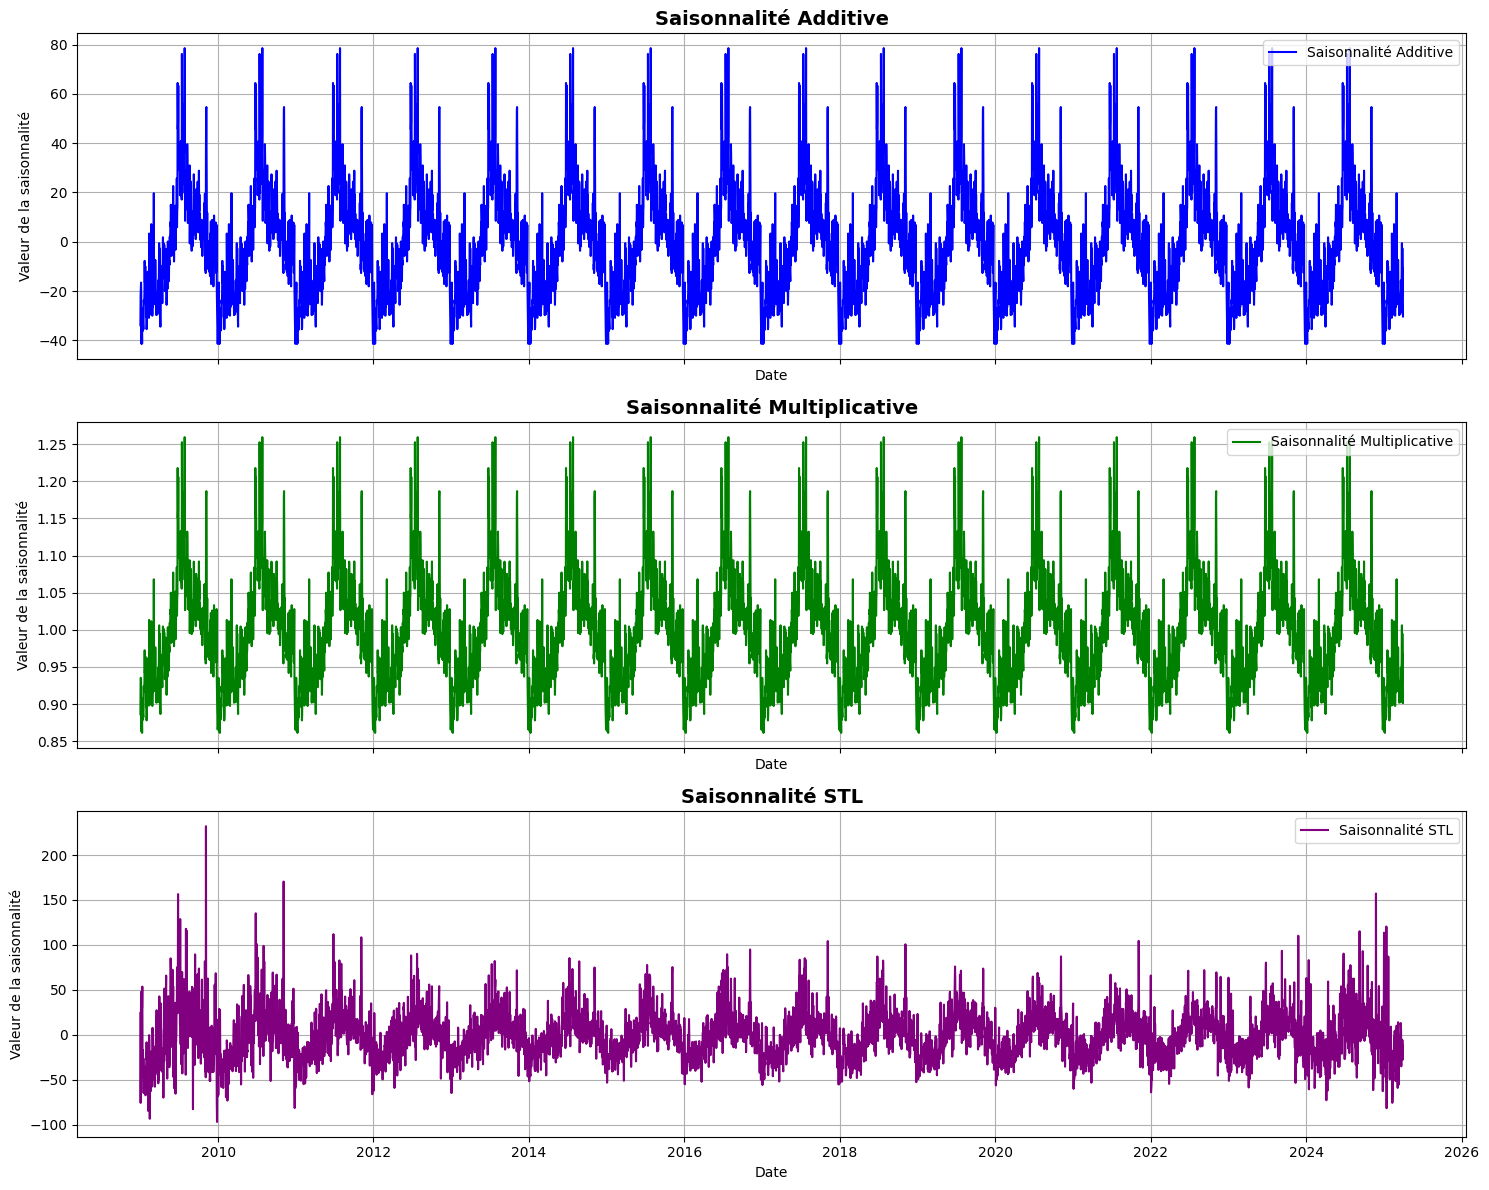

In [17]:
# Décomposition Additive
decomp_add = seasonal_decompose(inc_daily, model="additive", period=365)

# Décomposition Multiplicative
inc_daily_nonzero = inc_daily[inc_daily> 0]
decomp_mult = seasonal_decompose(inc_daily_nonzero, model="multiplicative", period=365)

# Décomposition STL
stl = STL(inc_daily, period=365, robust=True)
res_stl = stl.fit()

# Affichage comparatif des composantes
fig, axes = plt.subplots(3, 4, figsize=(20, 10), sharex=True)

# Additive
axes[0, 0].plot(decomp_add.observed)
axes[0, 0].set_title('Additive - Observed')
axes[0, 1].plot(decomp_add.trend)
axes[0, 1].set_title('Additive - Trend')
axes[0, 2].plot(decomp_add.seasonal)
axes[0, 2].set_title('Additive - Seasonal')
axes[0, 3].plot(decomp_add.resid)
axes[0, 3].set_title('Additive - Residual')

# Multiplicative
axes[1, 0].plot(decomp_mult.observed)
axes[1, 0].set_title('Multiplicative - Observed')
axes[1, 1].plot(decomp_mult.trend)
axes[1, 1].set_title('Multiplicative - Trend')
axes[1, 2].plot(decomp_mult.seasonal)
axes[1, 2].set_title('Multiplicative - Seasonal')
axes[1, 3].plot(decomp_mult.resid)
axes[1, 3].set_title('Multiplicative - Residual')

# STL
axes[2, 0].plot(res_stl.observed)
axes[2, 0].set_title('STL - Observed')
axes[2, 1].plot(res_stl.trend)
axes[2, 1].set_title('STL - Trend')
axes[2, 2].plot(res_stl.seasonal)
axes[2, 2].set_title('STL - Seasonal')
axes[2, 3].plot(res_stl.resid)
axes[2, 3].set_title('STL - Residual')

plt.tight_layout()
plt.show()

# Comparatif de la composante saisonnière uniquement
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
axes[0].plot(decomp_add.seasonal, label='Saisonnalité Additive', color='blue')
axes[0].set_title('Saisonnalité Additive', fontsize=14, fontweight='bold')
axes[1].plot(decomp_mult.seasonal, label='Saisonnalité Multiplicative', color='green')
axes[1].set_title('Saisonnalité Multiplicative', fontsize=14, fontweight='bold')
axes[2].plot(res_stl.seasonal, label='Saisonnalité STL', color='purple')
axes[2].set_title('Saisonnalité STL', fontsize=14, fontweight='bold')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set_ylabel('Valeur de la saisonnalité')
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

## **Analyse comparative des décompositions temporelles des incidents (2009-2025)**

###  Décomposition Additive

La décomposition additive suppose que les composantes **tendance, saisonnalité et bruit sont indépendantes et se superposent de façon constante**.
Elle met en évidence :

* Une **baisse des incidents jusqu'en 2016**, suivie d'une **remontée progressive jusqu'en 2025**.
* Une **saisonnalité fixe dans le temps**, peu réaliste dans un contexte urbain en évolution comme Londres.
* Des **résidus importants sur certains jours**, révélant des anomalies nettes, probablement liées à des événements exceptionnels.

Cette méthode est pédagogique mais manque de flexibilité sur une série aussi longue.

### Décomposition Multiplicative

La décomposition multiplicative suppose que **les effets saisonniers sont proportionnels au niveau général d'activité**.
Elle révèle :

* Une saisonnalité qui **s'ajuste au volume global** d’incidents : plus faible lorsque l’activité est basse, plus forte lorsqu’elle est haute.
* Des résidus plus homogènes, mais des anomalies subsistent.

Cette méthode est plus pertinente pour Londres où l’activité évolue selon le contexte (population, politique, environnement...).


### Décomposition STL (Seasonal-Trend-Loess)

La STL offre une lecture **plus souple et plus moderne** des séries temporelles :

* Une **tendance nette et lissée**, qui reflète bien les évolutions sociales et institutionnelles.
* Une **saisonnalité plus réaliste**, qui évolue dans le temps, s’ajustant aux changements d’habitudes, aux crises, etc.
* Des **résidus nets qui isolent bien les chocs ponctuels**, comme les jours d’incidents majeurs.

**La STL est la plus adaptée pour une ville comme Londres**, car elle capte les variations profondes, les cycles irréguliers et les évènements exceptionnels.


## 🚨 **Interprétation des anomalies**

Les **jours anormaux** détectés par toutes les méthodes correspondent probablement à des événements majeurs :

* **Émeutes de 2011** (été)
* **Grenfell Tower 2017**
* **Attentats de Londres (2017)**
* **Canicule 2022 (incendies)**
* **COVID-19 (2020)** : périodes atypiques d’activité inhabituelle

Ces journées **échappent à la saisonnalité classique et perturbent fortement les résidus**.


## **Conclusion**

| Méthode            | Avantage                        | Limite                           |
| ------------------ | ------------------------------- | -------------------------------- |
| **Additive**       | Lecture simple, claire          | Saisonnalité figée et irréaliste |
| **Multiplicative** | Effets proportionnels réalistes | Moins lisible, dépend du niveau  |
| **STL**            | Flexible, précise, robuste      | Plus technique à interpréter     |

**Pour une analyse fiable et des prévisions pertinentes, STL est la méthode la plus adaptée.**


 <span style="color:#e91e63; font-size:1em; font-weight:bold;"> 10-Modélisation</span>

 <span style="color:orange; font-size:1em; font-weight:bold;"> 1-SARIMA (1,1,0) (1,0,0,365) avec saisonnalité annuelle</span>
 

In [ ]:
#Préparation et modèle

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Série corrigée : inc_daily_fixed 
# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalité annuelle (365 jours)
model = SARIMAX(inc_daily_fixed, order=(1, 1, 0), seasonal_order=(1, 0, 0, 365))
model_fit = model.fit(disp=False, maxiter=50)


# Générer dates futures 2025-04-01 → 2027-12-31
future_dates = pd.date_range(start='2025-04-01', end='2027-12-31', freq='D')

# Prédiction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des résultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (Avril 2025-2027)', linestyle='--', linewidth=2)
plt.title("Prévision incidents journaliers Avril 2025-2027 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MemoryError: Unable to allocate 5.96 GiB for an array with shape (367, 367, 5935) and data type float64

Trop couteux en calcul pour mon pc des heures sans aboutir "boucle"

 <span style="color:orange; font-size:1em; font-weight:bold;"> 2-SARIMA (2,0,1) (0,1,1,365) avec saisonnalité annuelle</span>


In [ ]:
#Préparation et modèle
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMAX (p,d,q) (P,D,Q,s) avec saisonnalité annuelle (365 jours)
model = SARIMAX(inc_daily, order=(2, 0, 1), seasonal_order=(0, 1, 1, 365))
model_fit = model.fit(disp=False)

# Générer dates futures 2025-04-01 → 2027-12-31
future_dates = pd.date_range(start='2025-04-01', end='2027-12-31', freq='D')

# Prédiction
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

#Visualisation des résultats

plt.figure(figsize=(16, 5))
plt.plot(inc_daily_fixed.index, inc_daily_fixed, label='Historique (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (Avril 2025-2027)', linestyle='--', linewidth=2)
plt.title("Prévision incidents journaliers Avril 2025-2027 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nombre d'incidents")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Trop couteux en calcul pour mon pc des heures sans aboutir 

<span style="color:orange; font-size:1em; font-weight:bold;"> 3-SARIMA mensuel (1, 1, 0) (0, 1, 1, 12) (saison annuelle de 12 mois)  </span>


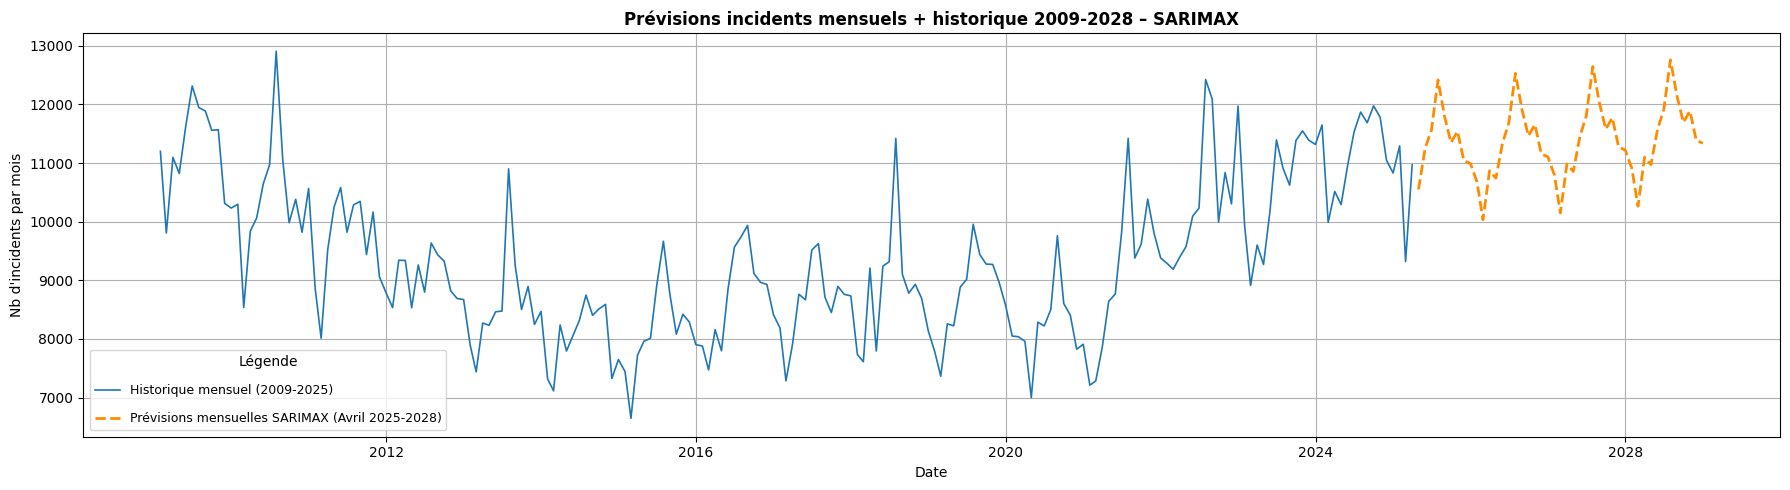

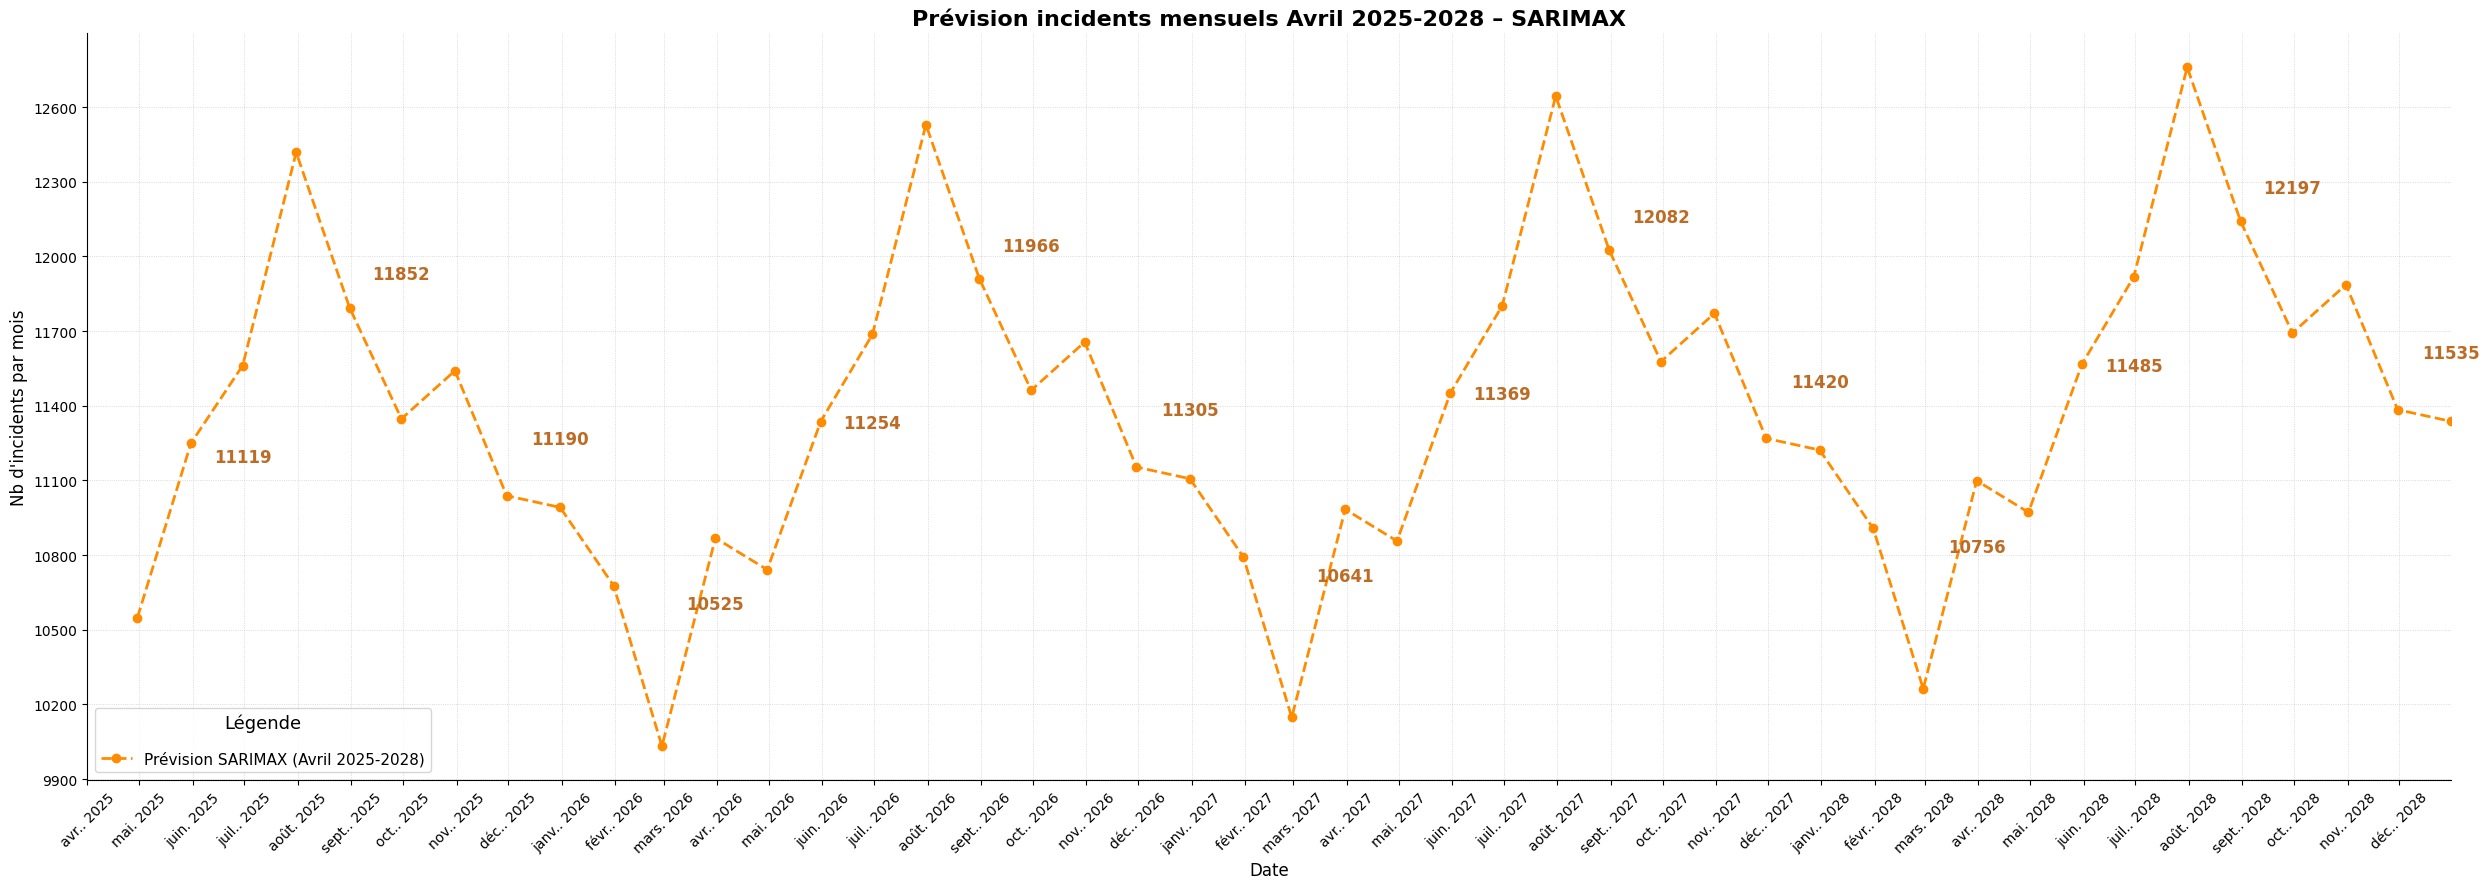

In [18]:
# Reformater en mensuel
inc_monthly = inc_daily.resample('M').sum()

# SARIMAX mensuel (saison annuelle de 12 mois)
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(inc_monthly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
model_fit = model.fit(disp=False)


# Générer les dates futures : avril 2025 à décembre 2027 ( approx 33 mois)
future_dates = pd.date_range(start='2025-04-01', end='2028-12-31', freq='M')

# Prévisions
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_values = forecast.predicted_mean
forecast_series = pd.Series(forecast_values.values, index=future_dates)

# Visualisation

plt.figure(figsize=(18, 5))
plt.plot(inc_monthly.index, inc_monthly, label='Historique mensuel (2009-2025)', linewidth=1.2)
plt.plot(forecast_series.index, forecast_series, label='Prévisions mensuelles SARIMAX (Avril 2025-2028)', linestyle='--', linewidth=2, color='darkorange')
plt.title("Prévisions incidents mensuels + historique 2009-2028 – SARIMAX", weight='bold')
plt.xlabel("Date")
plt.ylabel("Nb d'incidents par mois")
plt.legend(frameon=True, fancybox=True, fontsize=9, loc='lower left', title='Légende', title_fontsize='10', labelspacing=1.2)
plt.grid(True)
plt.tight_layout()
plt.show()
#____________
# Visualisation des avec zoom sur la période 2025-2028:
fig, ax = plt.subplots(figsize=(25, 9))
# Courbes
ax.plot(forecast_series.index, forecast_series, label='Prévision SARIMAX (Avril 2025-2028)', linestyle='--', linewidth=2, color='darkorange', marker='o', markersize=6)

# Annotations claires et visibles
quarterly_forecast = forecast_series.resample('Q').mean()
for x, y in zip(quarterly_forecast.index, quarterly_forecast.values):
    ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 10), textcoords='offset points', ha='center', fontsize=12, color='#bc6c25', fontweight='bold')

# Titre et axes
ax.set_title("Prévision incidents mensuels Avril 2025-2028 – SARIMAX", weight='bold', fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nb d'incidents par mois", fontsize=12)

# Axe X : mois lisibles
ax.set_xlim(pd.Timestamp('2025-04-01'), pd.Timestamp('2028-12-31'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %Y'))
ax.tick_params(axis='x', rotation=45)

# Axe Y : entiers uniquement
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

# Grille plus fine et discrète
ax.grid(True, linestyle=':', linewidth=0.6, alpha=0.6)

# Légende améliorée
ax.legend(frameon=True, fancybox=True, fontsize=11, loc='lower left', title='Légende', title_fontsize='13', labelspacing=1.2)

# Bordures allégées
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

### <span style="font-size:1em; font-weight:bold; text-decoration:underline; color:#197;"> Analyse des prévisions SARIMAX mensuelles (2025–2028):</span> 
#### **Tendance globale**
La courbe prévisionnelle révèle une **structure saisonnière marquée** avec des cycles annuels nets. On observe :

* Des **pics récurrents chaque été (juin à août)**, notamment visibles en 2026 et 2027.
* Des **creux systématiques autour de février-mars**, traduisant une saisonnalité régulière.

Cela est cohérent avec les tendances historiques observées jusqu’en 2025, où l’activité est généralement plus intense durant les mois estivaux. Ce comportement périodique est bien capturé par le composant saisonnier de SARIMAX.

---

#### **Amplitude et stabilité**
* Les valeurs mensuelles oscillent généralement entre **\~10 000 et 12 800 incidents/mois**.
* L’**amplitude reste relativement stable** sur les trois années projetées, sans rupture majeure ou changement structurel visible.
* Cela suggère que le modèle **anticipe une stabilité du système d’intervention à l’échelle mensuelle**, sans perturbation externe majeure (type COVID, grève, changement d’organisation…).
---

#### **Qualité des prévisions**
* Les prévisions sont **lisses, régulières et cohérentes**, preuve que SARIMAX s’adapte bien à la série temporelle agrégée mensuellement.
* L’absence d’irrégularité ou de bruit excessif montre que le modèle est **robuste et bien paramétré** pour capter le signal principal sans surajuster.
---

#### **Interprétation stratégique**
Cette projection peut être précieuse pour :

* **Anticiper les pics de charge opérationnelle** : les mois de juin-juillet nécessiteront un renfort de ressources.
* **Préparer les périodes creuses** (hiver) pour la maintenance ou la formation.
* Identifier la **récurrence annuelle des besoins** afin de renforcer la planification prévisionnelle des services d’intervention.
---

#### **Conclusion**
Le modèle SARIMAX mensuel offre une **vision synthétique, stable et intelligible** des tendances à moyen terme (2025–2028). Il est particulièrement adapté pour les analyses de **capacité opérationnelle globale**, bien que moins précis au jour le jour (cf. Prophet pour cela).
En somme, **un outil solide pour la planification stratégique annuelle**.

 <span style="color:orange; font-size:1.5em; font-weight:bold;"> 4-Prophet </span>


Pour répondre à la problématique du sarima annuel journalier qui est couteux en calcul nous testons le prophet pour les prévisions journaliere. A titre d'évaluation et de comparatif avec le sarima il sera aggrégé en mensuel par la suite pour avoir la meme maille de comparaison  

11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:33 - cmdstanpy - INFO - Chain [1] done processing


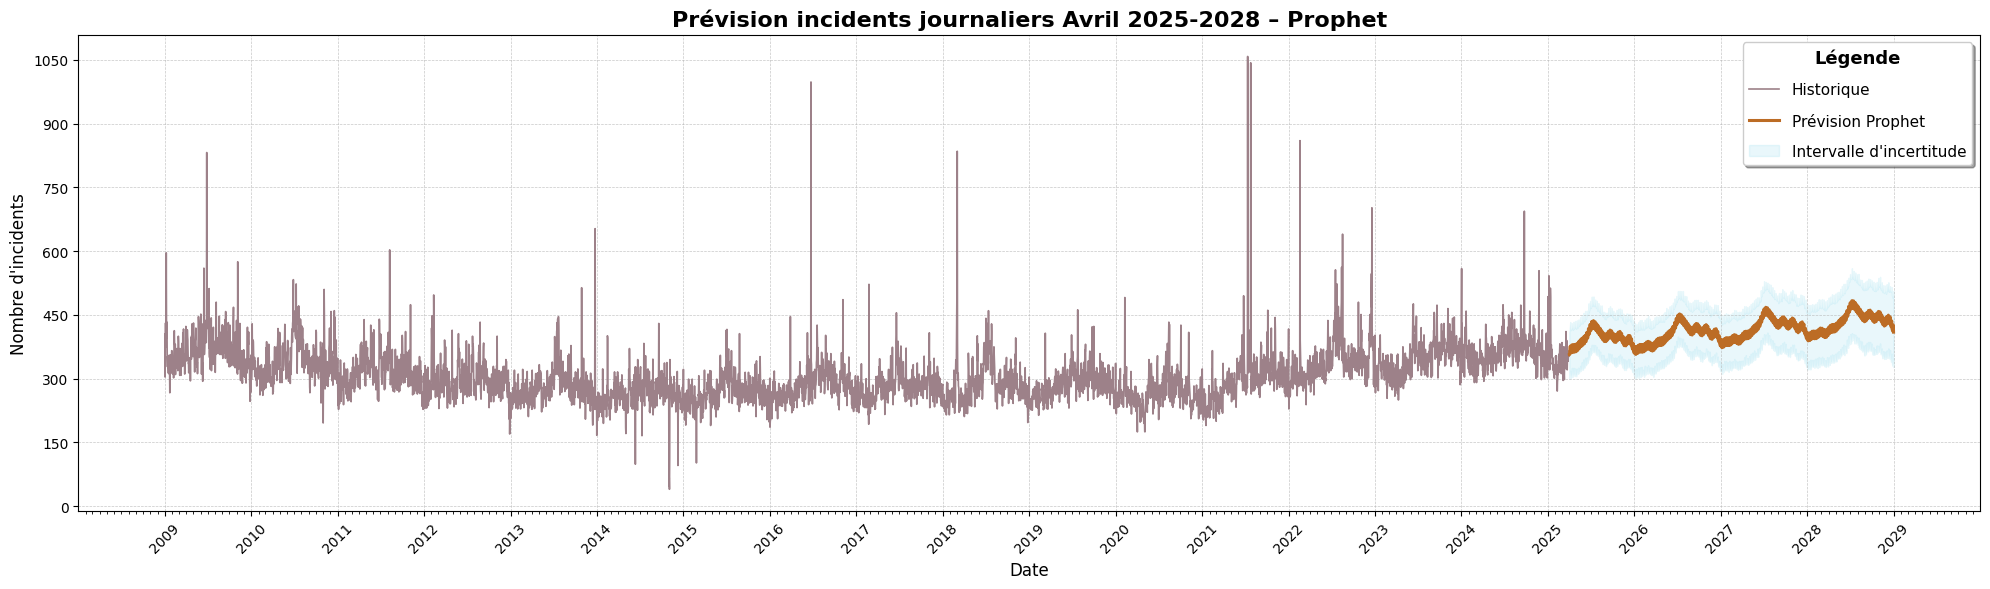

In [19]:
#Modélisation Prophet Journalière avec saisonnalité annuelle et hebdomadaire:

# Couleurs personnalisées
colors = {
    "historical": "#9d8189",
    "forecast": "#bc6c25",
    "uncertainty": "#a0e0f0"
}
forecast_color = colors["forecast"]

# 1. Formatage pour Prophet
from prophet import Prophet

df_prophet = inc_daily.reset_index()
df_prophet.columns = ['ds', 'y']

# 2. Modèle Prophet
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model_prophet.fit(df_prophet)

# 3. Génération des dates futures
future = model_prophet.make_future_dataframe(periods=1372, freq='D')
future = future[(future['ds'] > '2025-03-31') & (future['ds'] <= '2028-12-31')]

# 4. Prédictions
forecast_prophet = model_prophet.predict(future)

# 5. Visualisation
plt.figure(figsize=(20, 6))
# Historique
plt.plot(df_prophet['ds'], df_prophet['y'], color=colors['historical'], linewidth=1.2, label='Historique')
# Prévision
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], color=forecast_color, linewidth=2.2, label='Prévision Prophet')

# Incertitude (bande)
plt.fill_between(forecast_prophet['ds'], forecast_prophet['yhat_lower'], forecast_prophet['yhat_upper'], color=colors["uncertainty"], alpha=0.23, label="Intervalle d'incertitude")

# Titres & axes
plt.title("Prévision incidents journaliers Avril 2025-2028 – Prophet", weight='bold', fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Nombre d'incidents", fontsize=12)


# Affichage des années et des mois
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().tick_params(axis='x', rotation=45)

# Axe Y entier + grille
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Légende encadrée, propre
leg = plt.legend(frameon=True, fancybox=True, fontsize=11, loc='upper right', title='Légende', title_fontsize='13', labelspacing=1, shadow=True)
leg.get_title().set_fontweight('bold')
plt.tight_layout()
plt.show()

<span style="font-size:0.8em; font-weight:bold; text-decoration:underline; color:#1976d2;"> Justification de la sésonnalité choisie:</span>

 En configurant Prophet avec les saisonnalités annuelles et hebdomadaires (yearly_seasonality=True, weekly_seasonality=True), on capte à la fois les tendances longues et les rythmes hebdomadaires potentiellement liés à l’organisation des services ou aux habitudes de la population. La saisonnalité journalière (daily_seasonality) a été laissée désactivée, car elle ne s’applique pas à une série agrégée au jour.

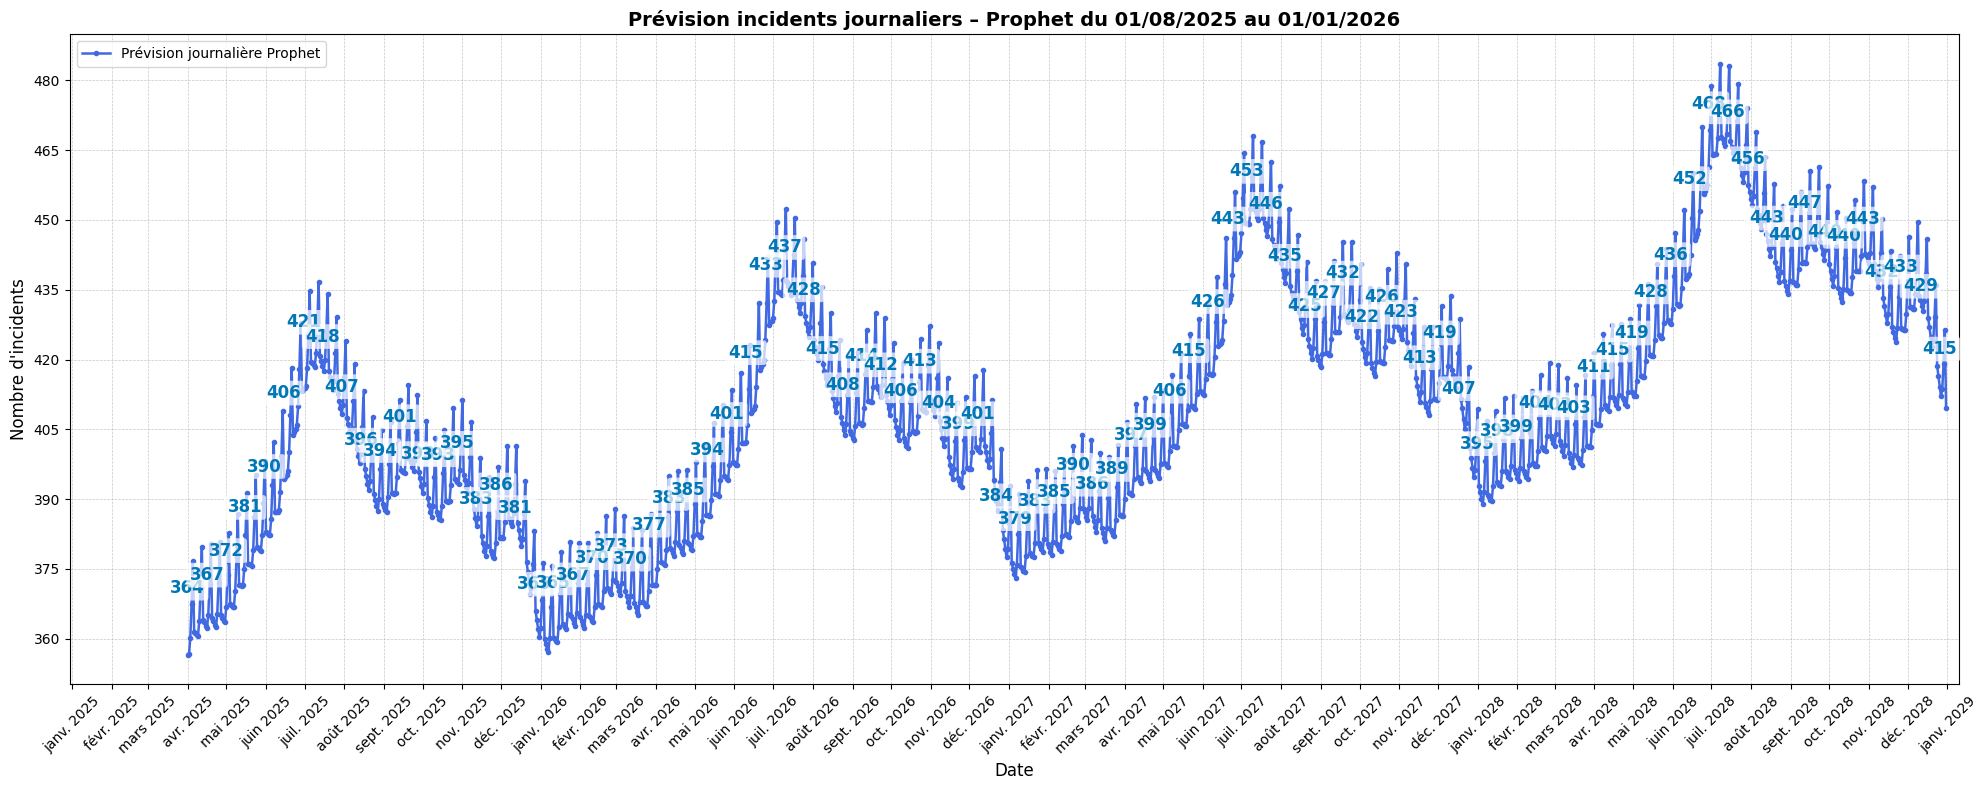

In [20]:
# visualisation du prophet zoomer sur une priode allant d'avril 2025 à fin 28 pour montrer au mieux les valeurs obtenues:
# 1. Filtrage de la période souhaitée
df_zoom = forecast_prophet[(forecast_prophet['ds'] >= '2025-04-01') & (forecast_prophet['ds'] <= '2028-12-31')]

# 2. Initialisation figure
fig, ax = plt.subplots(figsize=(20, 8))

# 3. Tracé de la courbe
ax.plot(df_zoom['ds'], df_zoom['yhat'], linestyle='-', linewidth=1.8, marker='o', markersize=3, color='royalblue', label="Prévision journalière Prophet")

# 4. Annotations tous les 15 jours avec encadré lisible
annotation_points = df_zoom.set_index('ds').resample('15D').mean()
for x, y in zip(annotation_points.index, annotation_points['yhat']):
    ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 18), textcoords='offset points', ha='center', fontsize=12, fontweight='bold', color='#0077b6', bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor='none'))

# 5. Mise en forme
ax.set_title("Prévision incidents journaliers – Prophet du 01/08/2025 au 01/01/2026", fontsize=14, weight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nombre d'incidents", fontsize=12)

# 6. Axe X bien décalé aux extrémités
ax.set_xlim(pd.Timestamp('2024-12-30'), pd.Timestamp('2029-01-10'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', rotation=45)

# 7. Axe Y : entiers uniquement + grille
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

### <span style="font-size:1em; font-weight:bold; text-decoration:underline; color:#197;"> Analyse des prévisions journalières – Modèle Prophet (2025–2028) :</span> 

1. Tendance globale maîtrisée mais croissante
La composante trend révèle une croissance lente mais continue du nombre quotidien d’incidents sur la période projetée. Cela laisse penser à une légère intensification de l’activité opérationnelle des pompiers à Londres à moyen terme. Cette dynamique peut être liée à des facteurs structurels comme l’urbanisation ou le climat.

2. Saisonnalité hebdomadaire bien captée
Le modèle met en évidence une structure hebdomadaire forte :

Le pic d’incidents a lieu les samedis, suivi du vendredi.
Les niveaux les plus faibles sont observés en début de semaine, particulièrement les mardis et mercredis.
Cette saisonnalité traduit des comportements collectifs (sorties, circulation, activité sociale accrue en fin de semaine) ayant un impact sur la fréquence des incidents.

3. Saisonnalité annuelle nette
La saisonnalité annuelle affiche un maximum marqué autour de juillet et un minimum entre décembre et février :

Le pic est sans surprise, car l'été voit traditionnellement une hausse des activités extérieures (barbecues, canicules, feux de végétation).
La baisse en hiver peut être due à une plus grande vigilance ou à une réduction des déplacements.
Le modèle capte bien cette logique saisonnière, confirmée par les données historiques.

4. Intervalle de confiance raisonnable
Les bandes d’incertitude (zones bleues claires) sont relativement étroites sur la période de prévision, témoignant d’un modèle stable et confiant dans ses projections. Cependant, l’élargissement progressif à l’horizon 2028 est logique, car l’incertitude augmente avec le temps.

5. Comportement journalier régulier et réaliste
À l’échelle journalière, les fluctuations prédites sont cohérentes, sans sur-ajustement. Prophet évite les oscillations brutales et produit un signal lissé mais fidèle à la dynamique sous-jacente.

### **Conclusion**
Le modèle Prophet fournit une prévision fiable et interprétable à l’échelle quotidienne, en mettant en évidence les trois dimensions temporelles clés (tendance, semaine, année). Il s'agit d'un outil pertinent pour la planification opérationnelle fine, notamment pour adapter les effectifs aux jours à risque ou anticiper les pics saisonniers. Toutefois, sa précision pourrait encore être renforcée par l’intégration d’effets exogènes (fériés, météo, événements locaux ...).

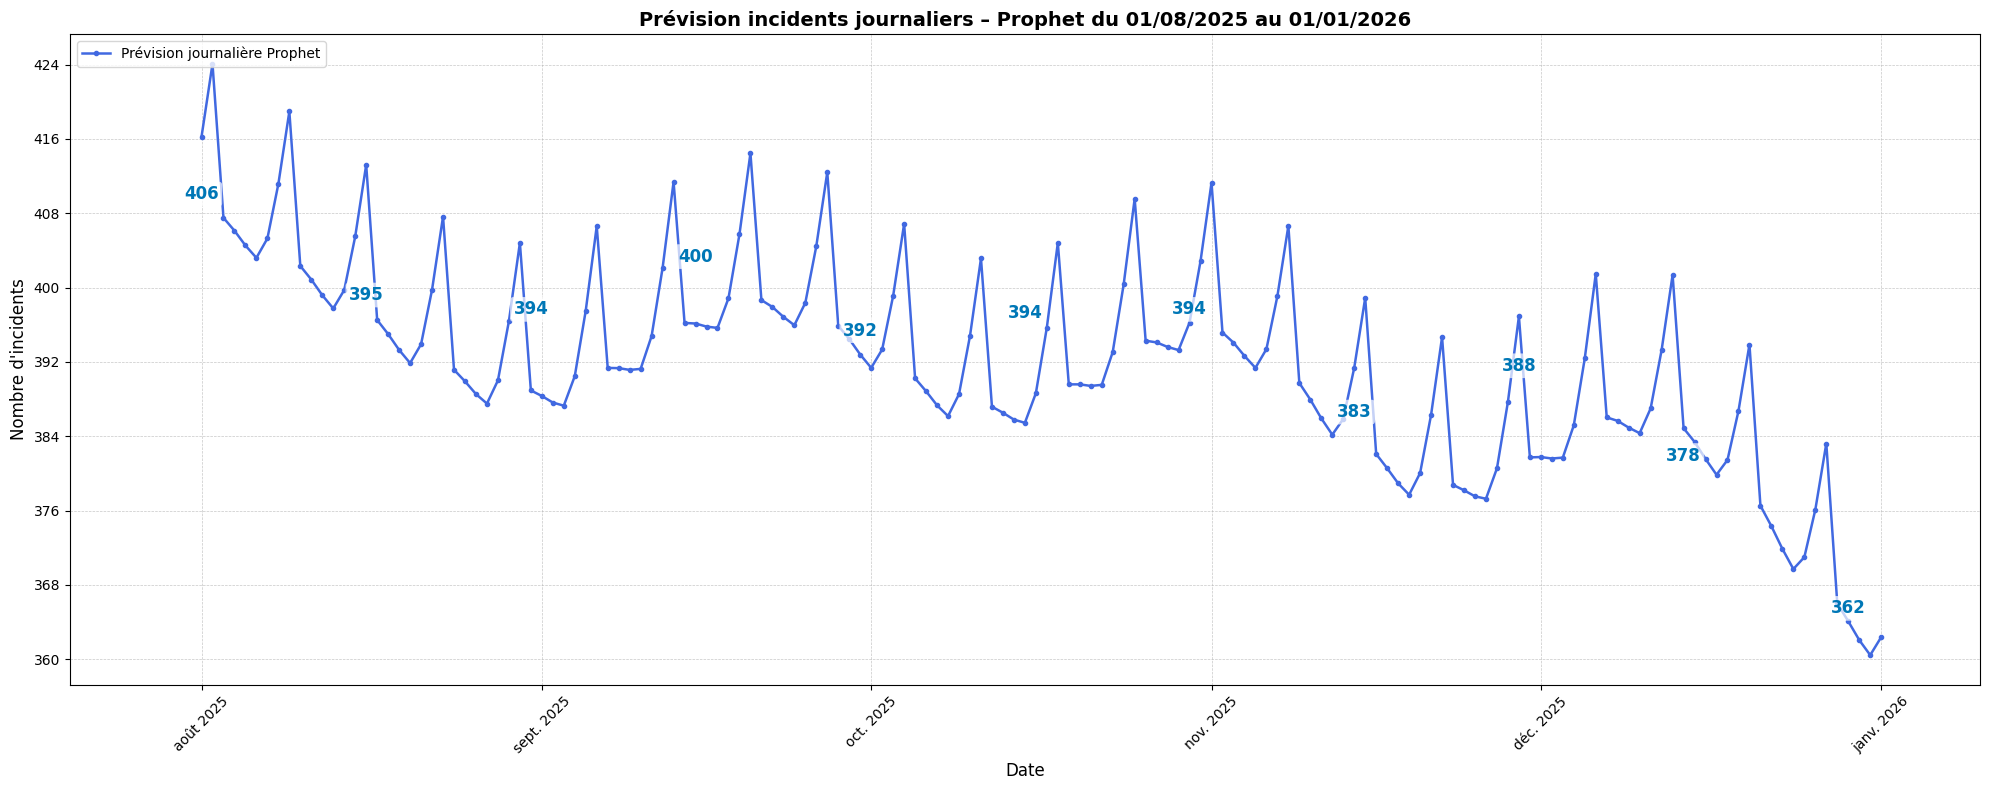

In [21]:
# visualisation du prophet zoomer sur une priode allant du 1er août 2025 au 1er janvier 2026 pour montrer au mieux les valeurs obtenues:
# 1. Filtrage de la période souhaitée
df_zoom = forecast_prophet[(forecast_prophet['ds'] >= '2025-08-01') & (forecast_prophet['ds'] <= '2026-01-01')]

# 2. Initialisation figure
fig, ax = plt.subplots(figsize=(20, 8))

# 3. Tracé de la courbe
ax.plot(df_zoom['ds'], df_zoom['yhat'], linestyle='-', linewidth=1.8, marker='o', markersize=3, color='royalblue', label="Prévision journalière Prophet")

# 4. Annotations tous les 15 jours avec encadré lisible
annotation_points = df_zoom.set_index('ds').resample('15D').mean()
for x, y in zip(annotation_points.index, annotation_points['yhat']):
    ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 18), textcoords='offset points', ha='center', fontsize=12, fontweight='bold', color='#0077b6', bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor='none'))

# 5. Mise en forme
ax.set_title("Prévision incidents journaliers – Prophet du 01/08/2025 au 01/01/2026", fontsize=14, weight='bold')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Nombre d'incidents", fontsize=12)

# 6. Axe X bien décalé aux extrémités
ax.set_xlim(pd.Timestamp('2025-07-20'), pd.Timestamp('2026-01-10'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', rotation=45)

# 7. Axe Y : entiers uniquement + grille
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

### <span style="font-size:1em; font-weight:bold; text-decoration:underline; color:#197;"> Analyse Prophet journalier (du 1 août 2025 – au 1 janvier 2026):</span> 
Le modèle Prophet capte efficacement les saisonnalités hebdomadaire et annuelle, avec des prévisions stables comprises entre 375 et 415 incidents par jour. Une légère baisse progressive est observée vers l’hiver, cohérente avec la saisonnalité annuelle. Les pics hebdomadaires réguliers montrent que le modèle saisit bien les rythmes d’activité opérationnelle.

La prédiction est fiable, lissée et interprétable, bien qu’elle reste conservatrice sur les événements extrêmes. Elle est particulièrement utile pour la planification quotidienne des équipes et l’anticipation à court terme.

In [25]:
# 1. Refais la prédiction sur toute la période historique (pas seulement futur)
future_full = model_prophet.make_future_dataframe(periods=0, freq='D')  # 0 = que l'historique
forecast_hist = model_prophet.predict(future_full)

# 2. Merge sur les dates historiques
eval_df = pd.merge(
    df_prophet[['ds', 'y']],           # historique vrai
    forecast_hist[['ds', 'yhat']],     # prévision Prophet sur historique
    on='ds',
    how='inner'
)

# 3. Évalue
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(eval_df['y'], eval_df['yhat'])
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
mape = np.mean(np.abs((eval_df['y'] - eval_df['yhat']) / (eval_df['y'] + 1e-10))) * 100

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f} %")


MAE : 27.62
RMSE : 42.85
MAPE : 9.04 %


## Évaluation du modèle Prophet

| **Métrique** | **Résultat**        | **Interprétation**                                                                           |
|--------------|---------------------|---------------------------------------------------------------------------------------------|
| MAE          | 27,62 incidents     | Erreur absolue moyenne : Prophet se trompe d’environ 28 incidents par jour, en moyenne.      |
| RMSE         | 42,85 incidents     | Les erreurs les plus importantes (jours exceptionnels) restent maîtrisées, mais existent.    |
| MAPE         | 9,04 %              | Erreur relative moyenne inférieure à 10 % : très bon niveau de précision pour ce contexte.   |

> **En résumé :**  
> Le modèle Prophet offre une très bonne précision sur la prévision quotidienne des incidents.  
> L’erreur moyenne reste faible et le modèle s’avère fiable pour la planification.  
> Les rares écarts importants sont liés à des jours atypiques, difficilement prévisibles.


In [ ]:
print(f"Début de la modélisation par groupes d'incidents : Fire, Special Service, False Alarm")

Début de la modélisation par groupes d'incidents : Fire, Special Service, False Alarm



<span style="color:orange; font-size:1em; font-weight:bold;"> 5- SARIMA mensuel pour les prédictions en fonctions des groupes d'incidents : Fire, False Alarm, Special Service </span>


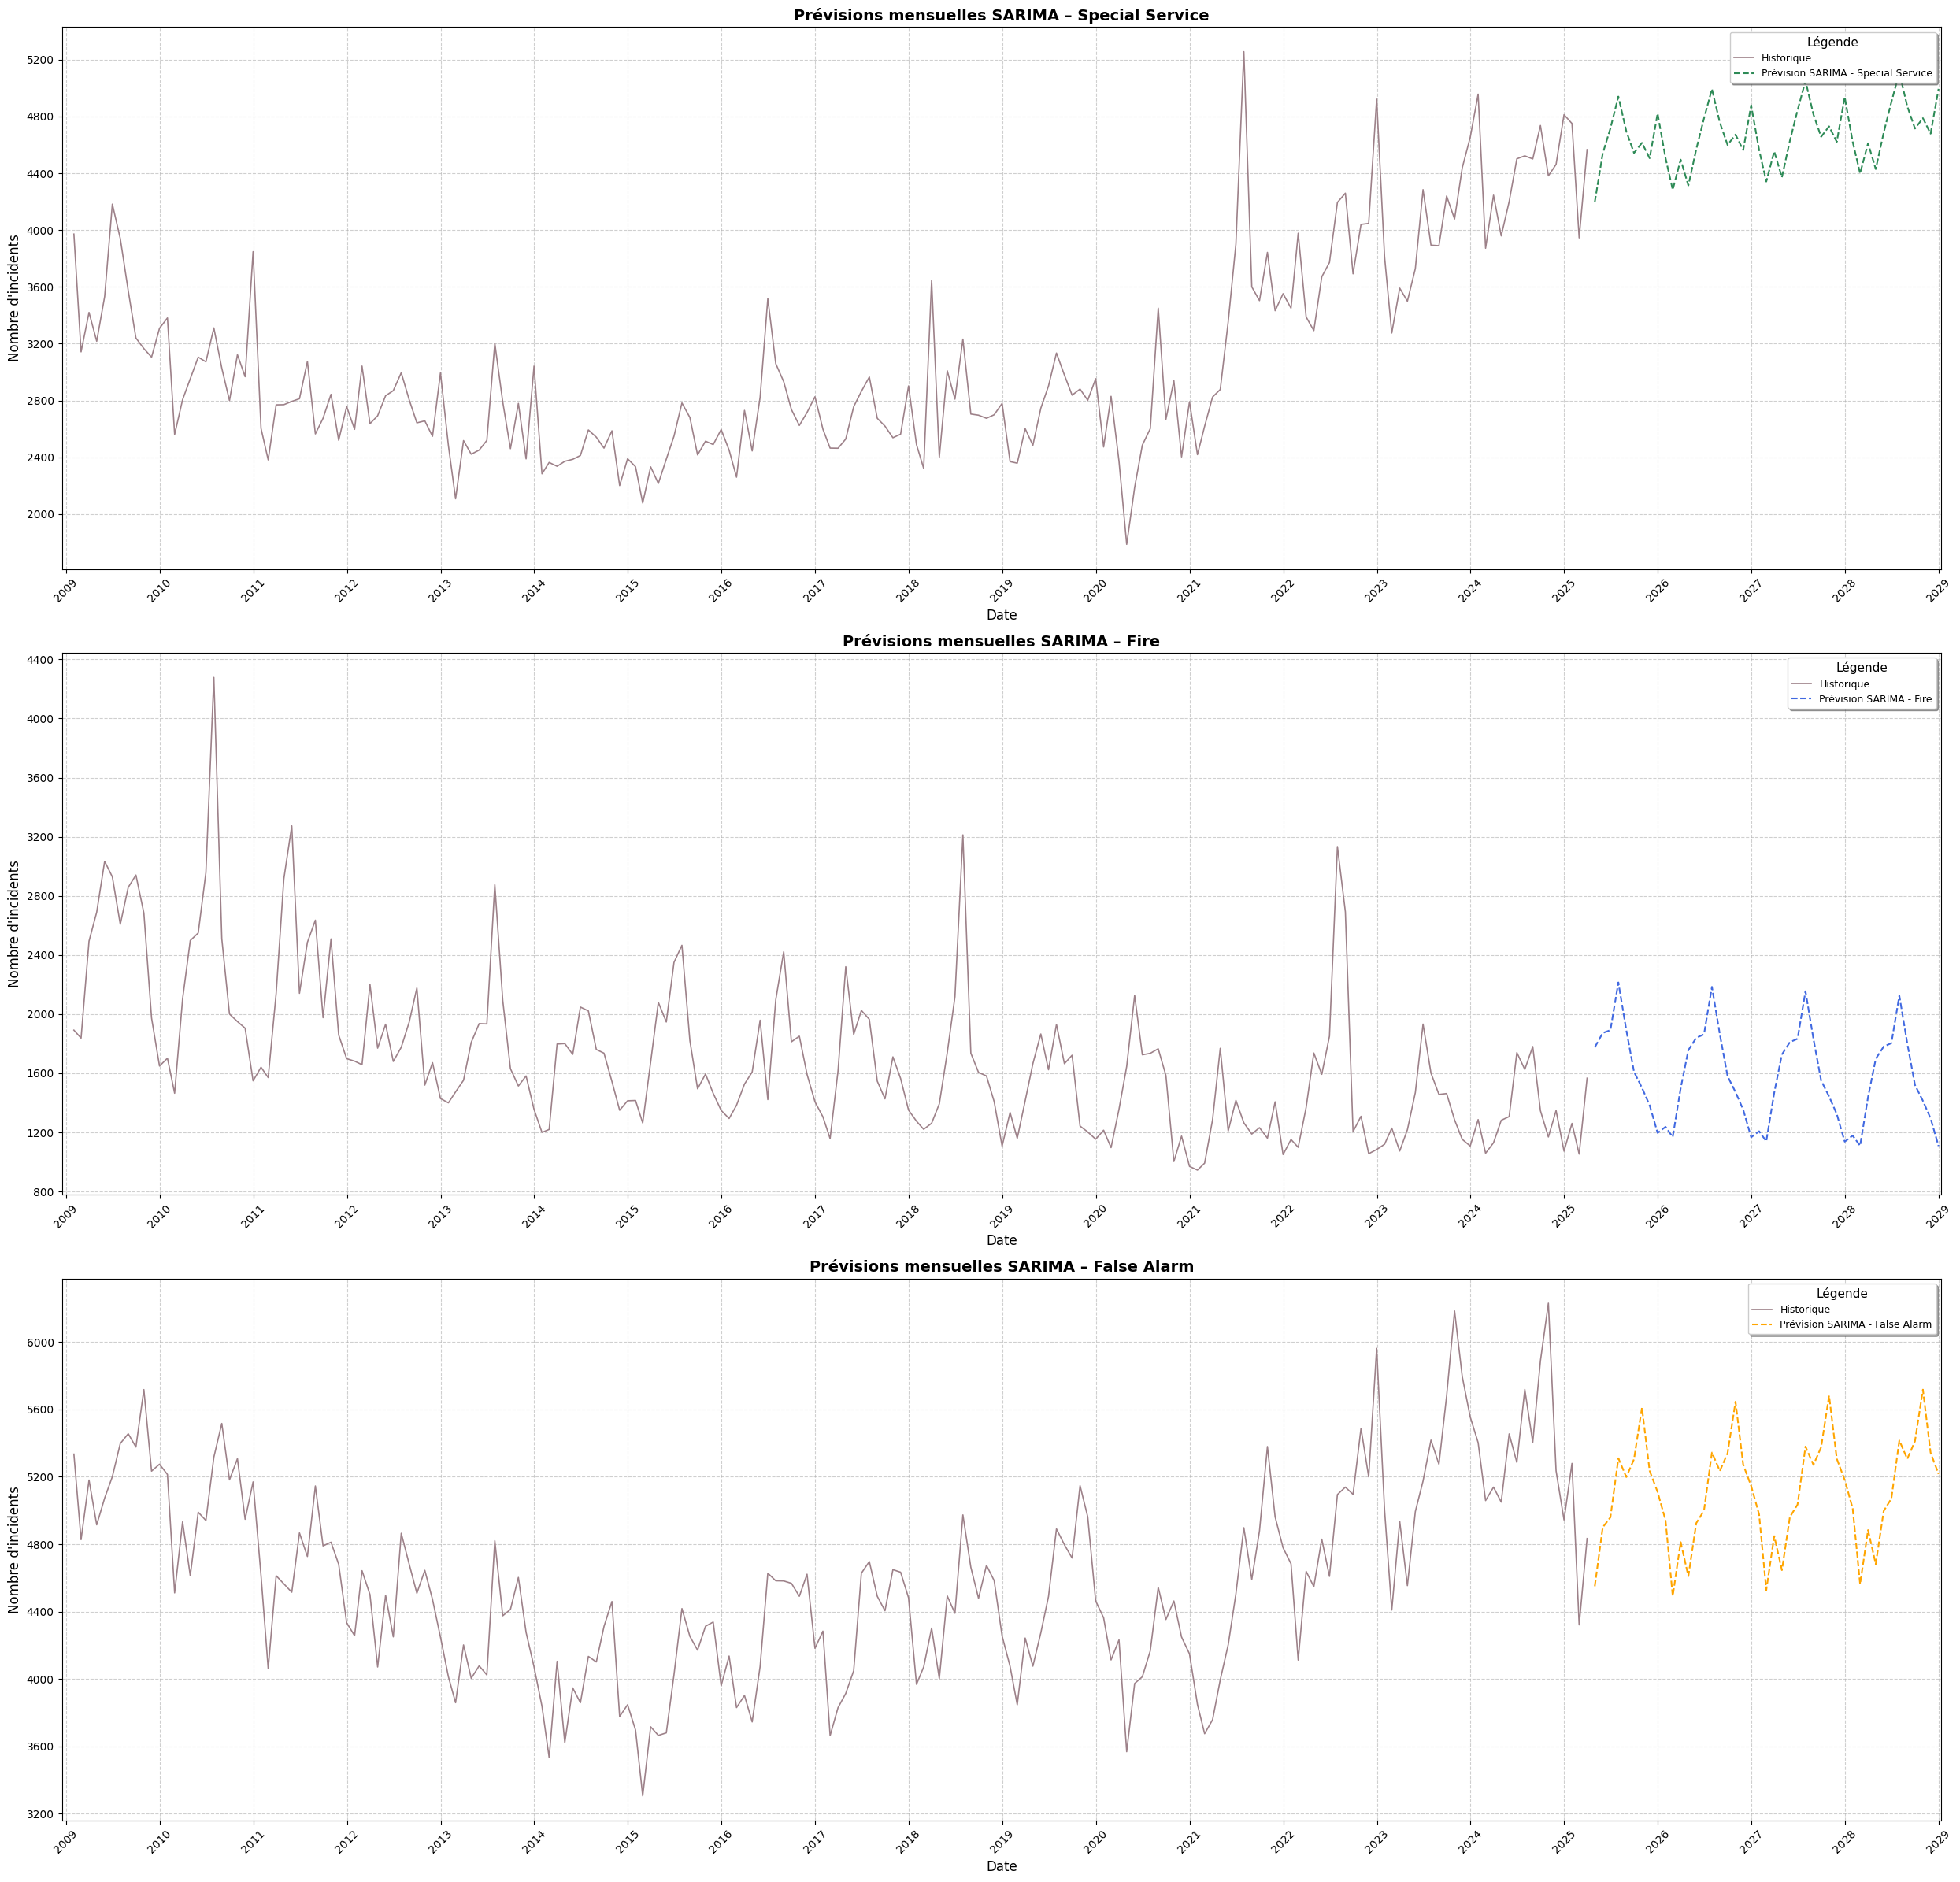

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

# Définition des groupes et couleurs
incident_groups = df['IncidentGroup'].dropna().unique()
colors = {
    "Fire": "royalblue",
    "False Alarm": "orange",
    "Special Service": "seagreen"
}

# Préparation de la plage de prévision
start_forecast = pd.Timestamp('2025-04-01')
end_forecast = pd.Timestamp('2028-12-31')
forecast_months = pd.date_range(start=start_forecast, end=end_forecast, freq='M')

# Dictionnaire pour stocker résultats
sarima_results = {}

for group in incident_groups:
    df_group = df[df['IncidentGroup'] == group]
    ts_group = df_group.resample('M')["IncidentNumber"].nunique().asfreq('M').fillna(0)

    # Entraînement SARIMAX
    model = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit = model.fit(disp=False)
    forecast = pd.Series(
        model_fit.get_forecast(steps=len(forecast_months)).predicted_mean.values,
        index=forecast_months
    )

    # Stocke historique et prévisions
    sarima_results[group] = {"historical": ts_group, "forecast": forecast}

# --- Visualisation ---
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(25, 8 * len(incident_groups)))
if len(incident_groups) == 1:
    axes = [axes]

for ax, group in zip(axes, incident_groups):
    res = sarima_results[group]
    color = colors.get(group, "grey")

    ax.plot(res["historical"].index, res["historical"].values, label="Historique", color='#9d8189', linewidth=1.2)
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', color=color, label=f"Prévision SARIMA - {group}")

    ax.set_title(f"Prévisions mensuelles SARIMA – {group}", fontsize=14, weight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2008-12-15'), pd.Timestamp('2029-01-10'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', which='major', rotation=45)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fancybox=True, fontsize=9, loc='upper right', title='Légende', title_fontsize='11', frameon=True, shadow=True)

plt.tight_layout()
plt.show()

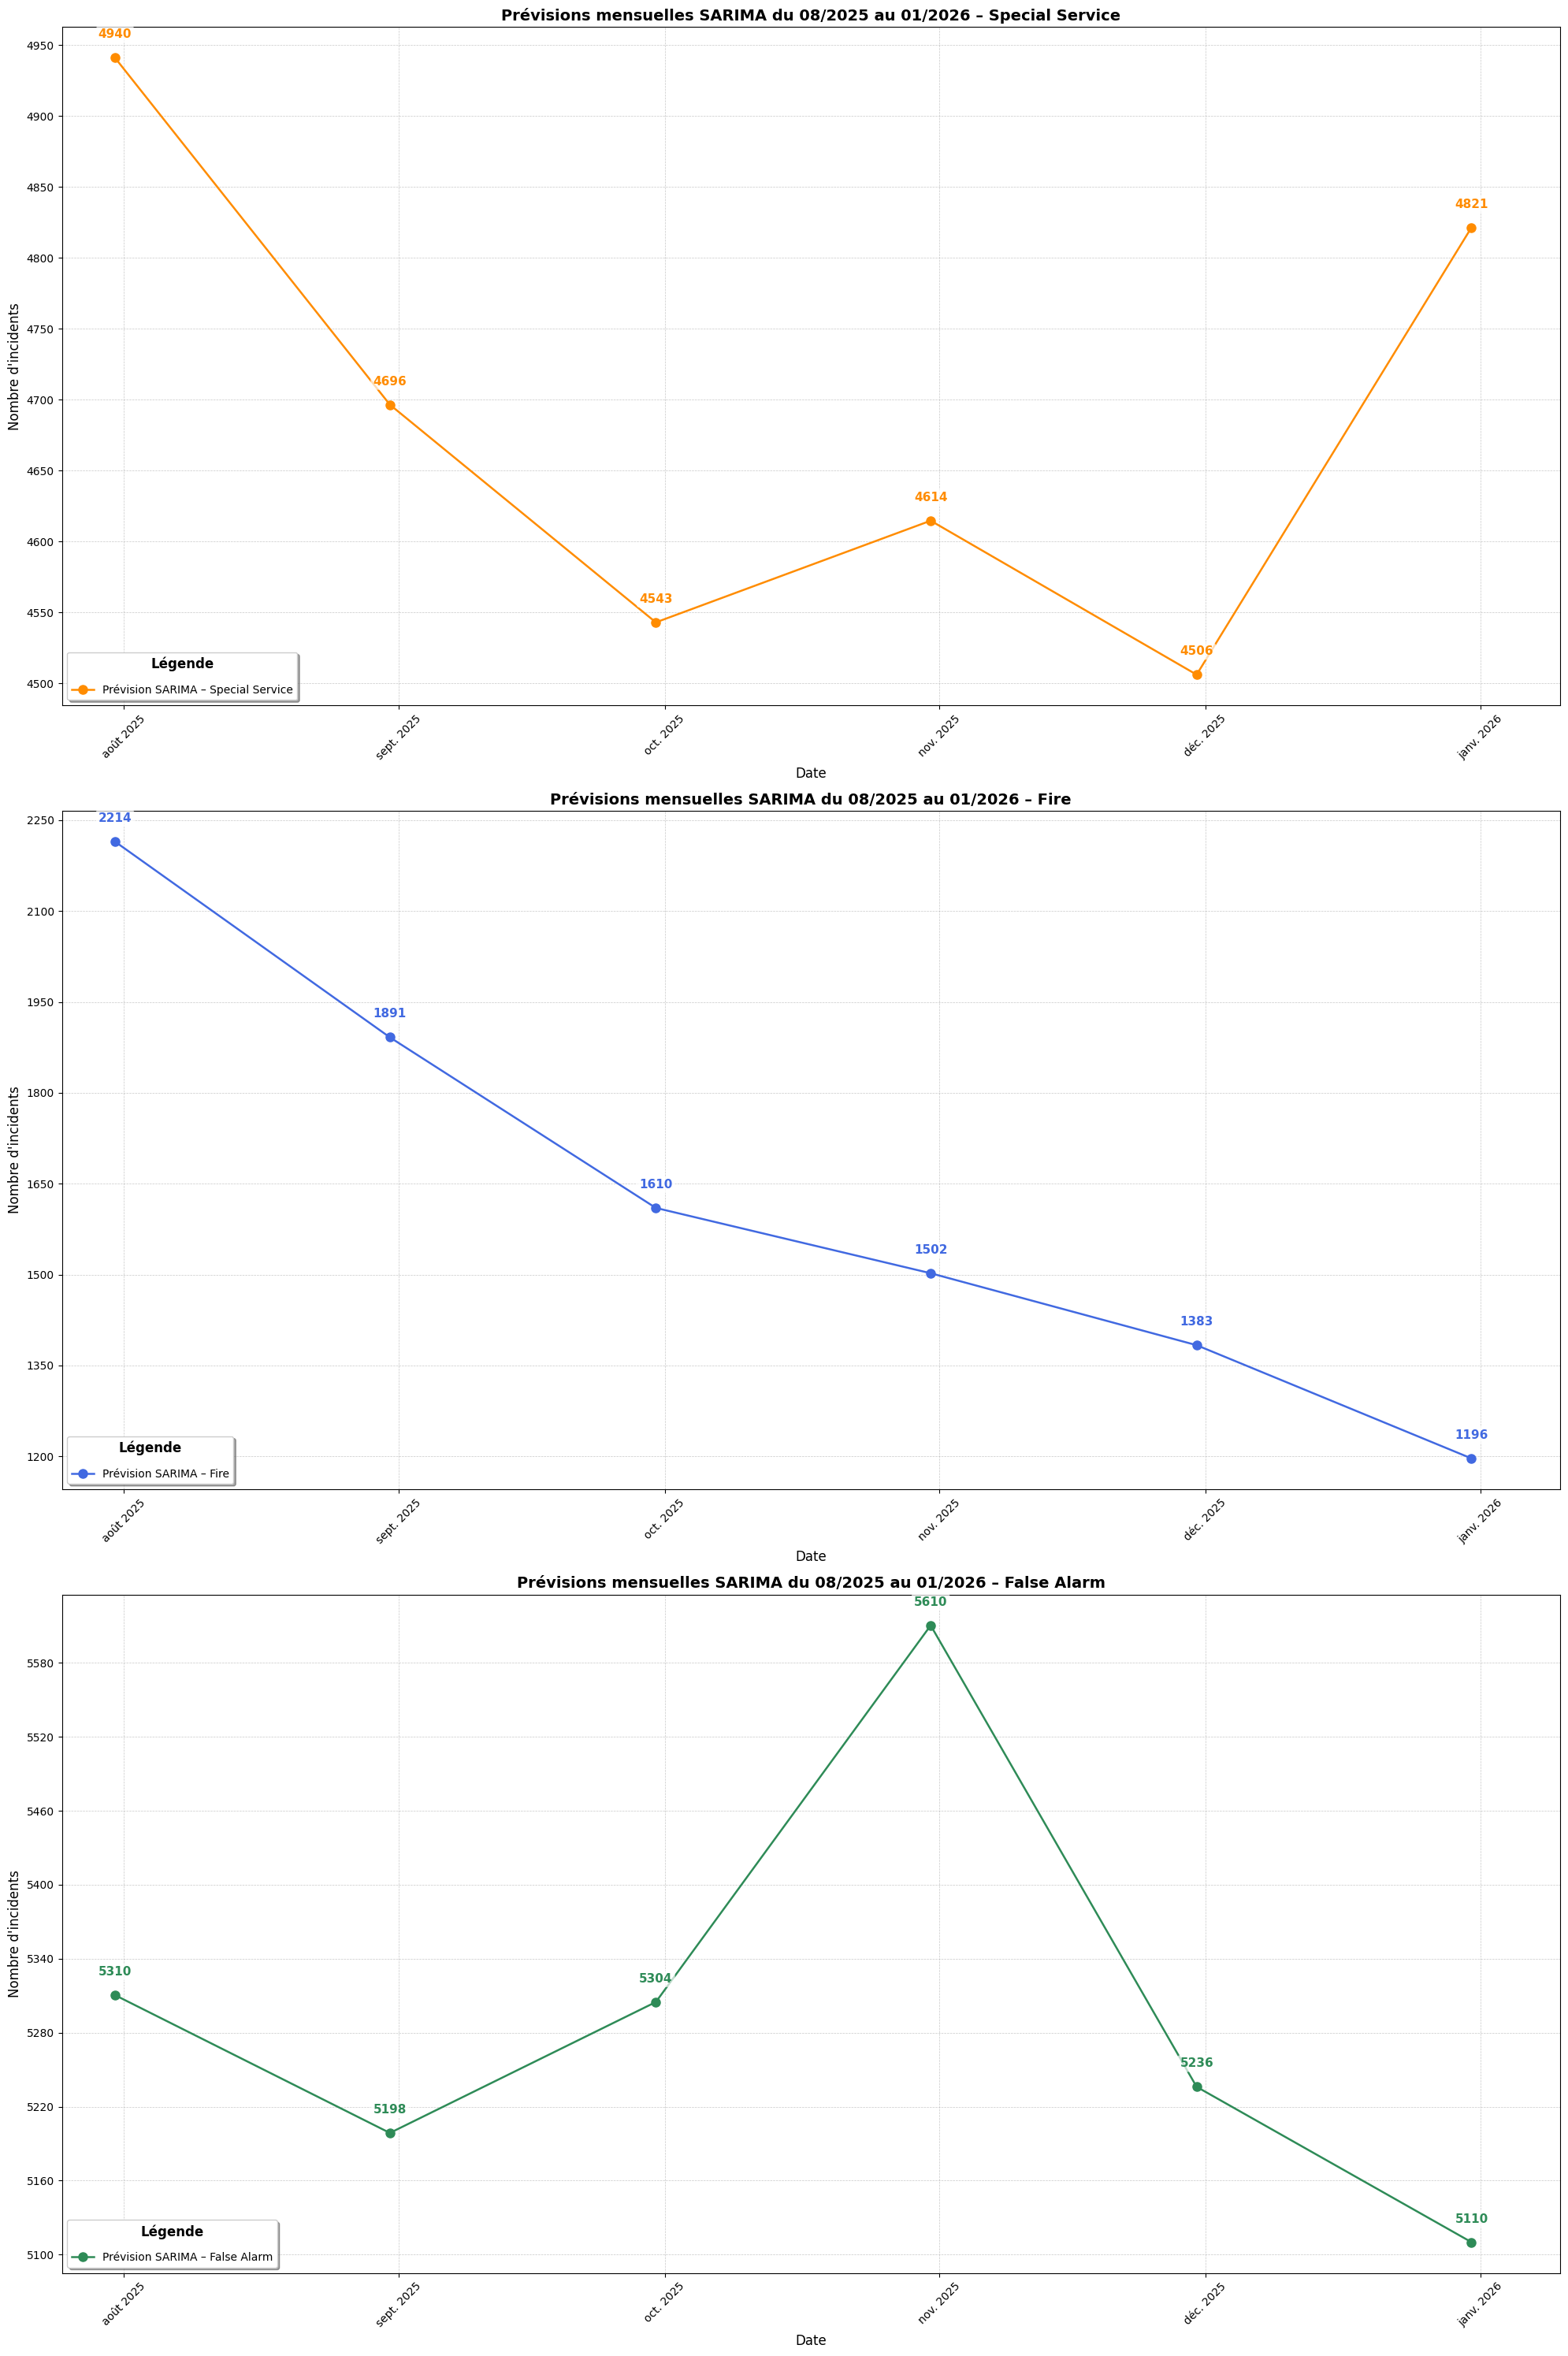

In [27]:
#zoom  SARIMA sur une période d'environ 6 mois du 1er aout 25 au 1er janv 26:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

mois_a_afficher = pd.date_range('2025-07-31', '2026-01-01', freq='M')  

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(20, 10 * len(incident_groups)))
if len(incident_groups) == 1:
    axes = [axes]

for ax, group in zip(axes, incident_groups):
    res = sarima_results[group]
    color = color_map.get(group, 'grey')

    # Sélection explicite
    zoom_forecast = res["forecast"].loc[mois_a_afficher]

    # Tracer la courbe prévisionnelle SARIMA
    ax.plot(zoom_forecast.index, zoom_forecast.values, linestyle='-', linewidth=1.8, marker='o', markersize=8, color=color, label=f"Prévision SARIMA – {group}")

    # Annotations sur chaque point (chaque mois)
    for x, y in zip(zoom_forecast.index, zoom_forecast.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 18), textcoords='offset points', ha='center', fontsize=11, fontweight='bold', color=color, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor='none'))

    # Titres & habillage
    ax.set_title(f"Prévisions mensuelles SARIMA du 08/2025 au 01/2026 – {group}", fontsize=14, weight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-07-25'), pd.Timestamp('2026-01-10'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=45)

    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    leg = ax.legend(fontsize=10, loc='lower left', title="Légende", title_fontsize=12, labelspacing=1.2, frameon=True, fancybox=True, shadow=True)
    leg.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

### Conclusion: 
Sur la période courte analysée (août 2025 à janvier 2026), les prévisions SARIMAX révèlent des comportements contrastés selon les groupes d’incidents :

-Une baisse continue pour les incendies, compatible avec les effets saisonniers.  
-Des variations plus erratiques pour les fausses alertes, suggérant une dynamique moins prédictible.   
-Une forme de saisonnalité marquée en creux pour les services spéciaux, avec un net rebond hivernal.

Ces observations confirment l’intérêt de dissocier les groupes dans la modélisation afin de mieux cerner les spécificités temporelles propres à chaque type d’intervention.

<span style="color:orange; font-size:1em; font-weight:bold;"> 6- Prophet pour les prédictions journalières en fonctions des groupes d'incidents : Fire, False Alarm, Special Service
 </span>

11:59:30 - cmdstanpy - INFO - Chain [1] start processing
11:59:33 - cmdstanpy - INFO - Chain [1] done processing
11:59:36 - cmdstanpy - INFO - Chain [1] start processing
11:59:36 - cmdstanpy - INFO - Chain [1] done processing
11:59:39 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing


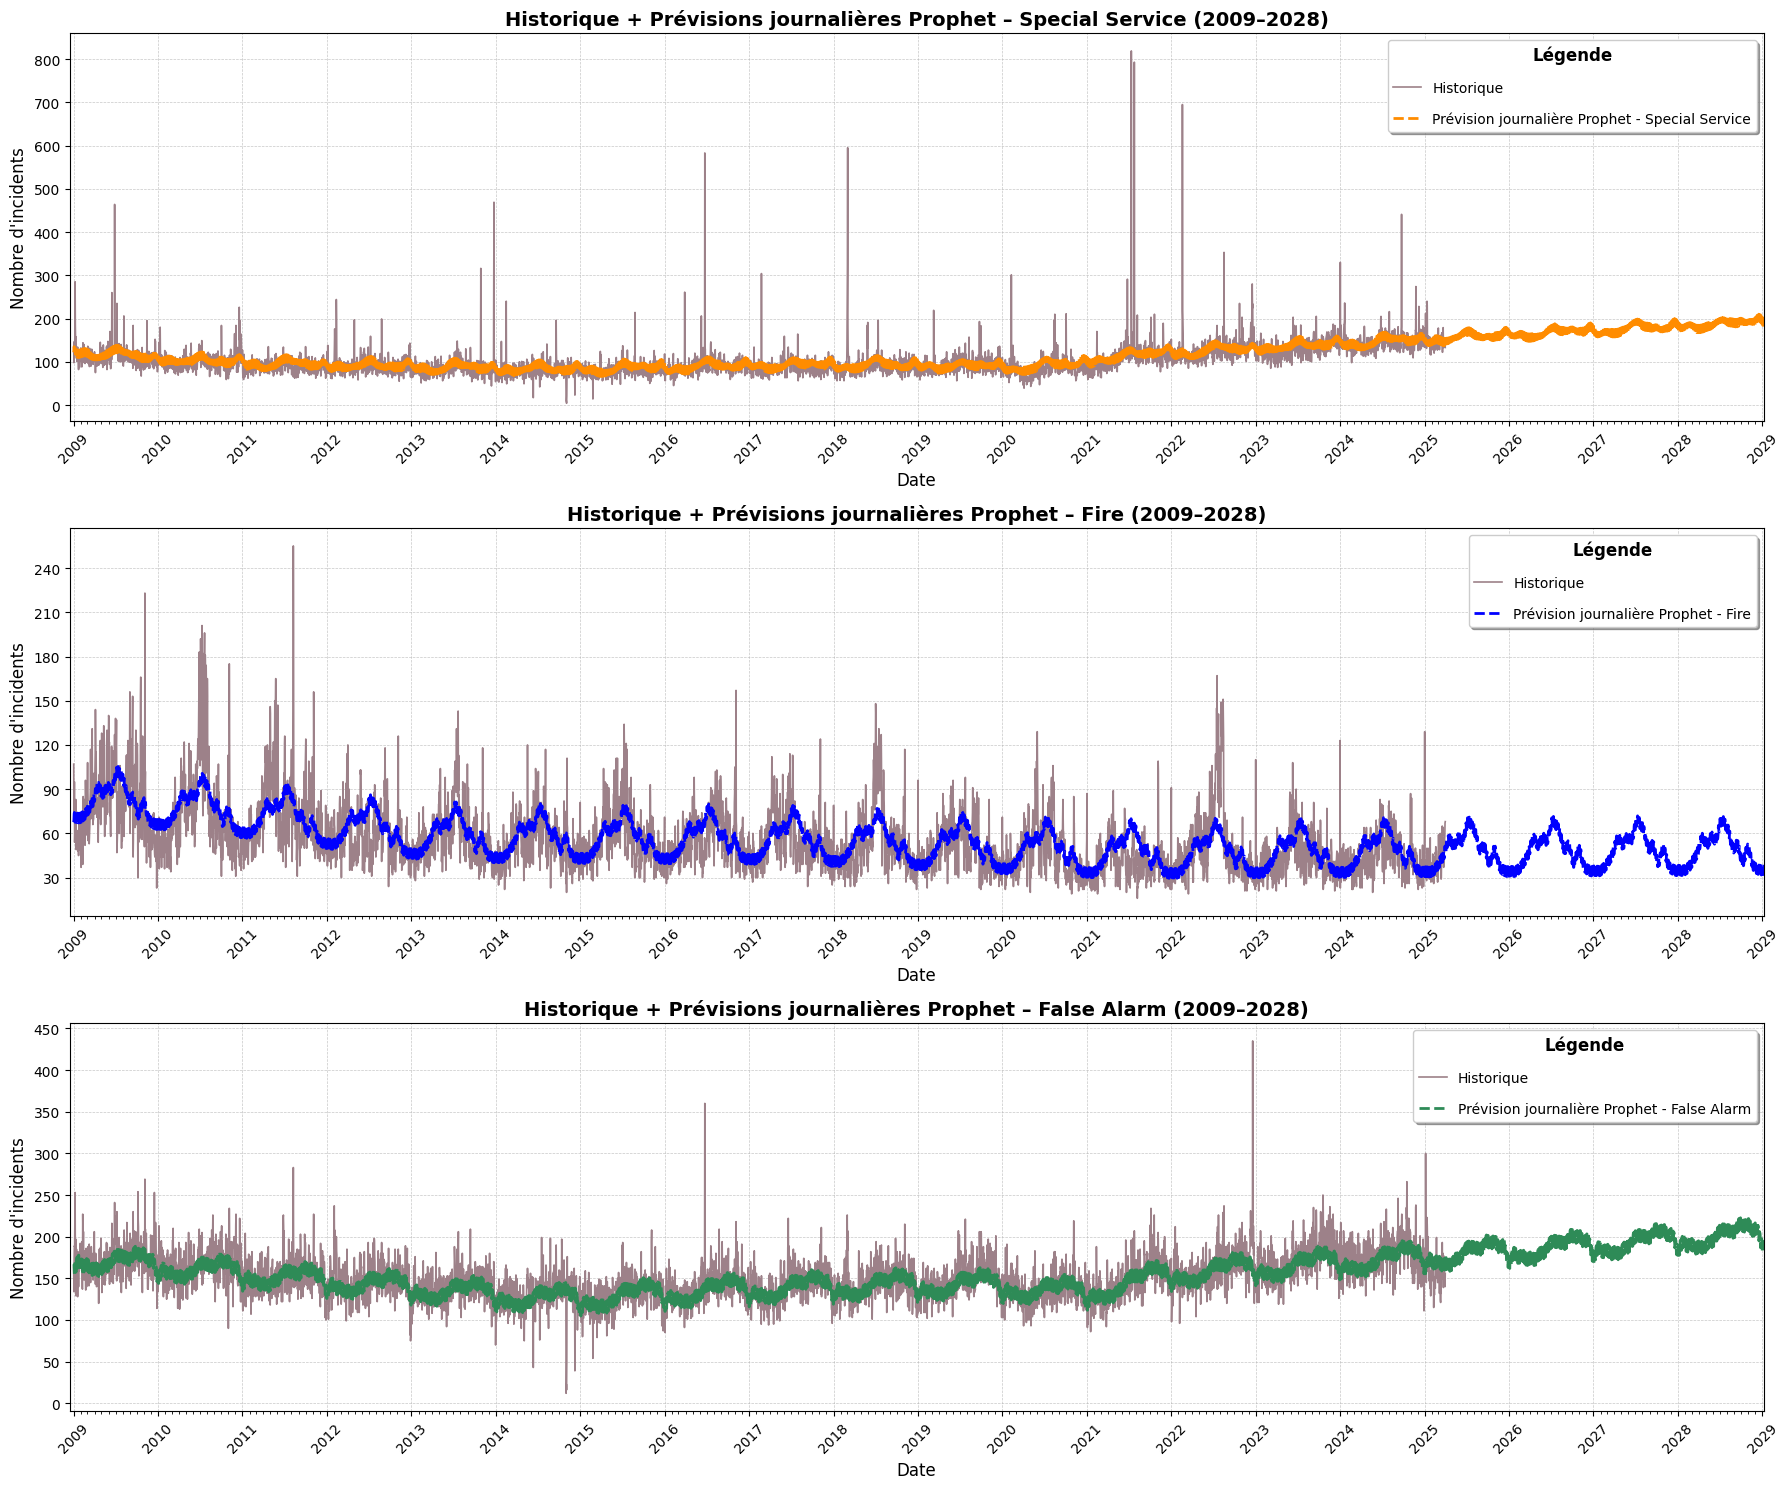

In [28]:
# Modelisation Prophet journalier par IncidentGroup
prophet_results_daily = {}

incident_groups = df['IncidentGroup'].dropna().unique()

for group in incident_groups:
    df_group = df[df['IncidentGroup'] == group]
    ts_group_daily = df_group.resample('D')["IncidentNumber"].nunique()
    ts_group_daily = ts_group_daily.asfreq('D').fillna(0).reset_index()
    ts_group_daily.columns = ['ds', 'y']

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model.fit(ts_group_daily)

    # Prévoir sur toute la période : historique + 1400 jours futurs
    future = model.make_future_dataframe(periods=1400, freq='D')
    forecast = model.predict(future)
    forecast_series = forecast.set_index('ds')['yhat']

    # fitted = valeurs prédites sur l'historique
    fitted = forecast_series.loc[ts_group_daily['ds']]

    prophet_results_daily[group] = {
        "forecast": forecast_series,
        "historical": ts_group_daily.set_index('ds')["y"],
        "fitted": fitted
    }

color_map = {
    'Fire': 'blue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

# Visualisation complète 2009–2028
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(18, 5 * len(incident_groups)))

if len(incident_groups) == 1:
    axes = [axes]

for ax, group in zip(axes, incident_groups):
    res = prophet_results_daily[group]
    color = color_map.get(group, 'grey')

    ax.plot(res["historical"].index, res["historical"].values, color='#9d8189', linestyle='-', linewidth=1.2, label='Historique')
    ax.plot(res["forecast"].index, res["forecast"].values, linestyle='--', linewidth=2, color=color, label=f"Prévision journalière Prophet - {group}")

    ax.set_title(f"Historique + Prévisions journalières Prophet – {group} (2009–2028)", weight='bold', fontsize=14)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)

    ax.set_xlim(pd.Timestamp('2008-12-15'), pd.Timestamp('2029-01-06'))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    (ax.legend(fontsize=10, loc='upper right', title='Légende', title_fontsize=12, labelspacing=1.2, frameon=True, fancybox=True, shadow=True).get_title().set_fontweight('bold'))

plt.tight_layout()
plt.show()


In [29]:
#Evaluation du prophet journalier par groupe d'incident:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Évaluation des performances Prophet par IncidentGroup
prophet_metrics = {}

for group in incident_groups:
    res = prophet_results_daily[group]
    y_true = res["historical"].values  # réel sur historique
    y_pred = res["fitted"].values      # prédit sur historique

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

    prophet_metrics[group] = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    }

# Affichage Markdown pour rapport
print("## Évaluation du modèle Prophet par IncidentGroup\n")
print("| IncidentGroup     | MAE         | RMSE        | MAPE (%)   |")
print("|-------------------|-------------|-------------|------------|")
for group in incident_groups:
    m = prophet_metrics[group]
    print(f"| {group:17} | {m['MAE']:.2f}      | {m['RMSE']:.2f}     | {m['MAPE']:.2f}      |")


## Évaluation du modèle Prophet par IncidentGroup

| IncidentGroup     | MAE         | RMSE        | MAPE (%)   |
|-------------------|-------------|-------------|------------|
| Special Service   | 13.04      | 27.06     | 13.18      |
| Fire              | 12.79      | 17.79     | 24.19      |
| False Alarm       | 14.24      | 19.20     | 10.01      |


## Évaluation du modèle Prophet par IncidentGroup

| IncidentGroup     | MAE         | RMSE        | MAPE (%)   |
|-------------------|-------------|-------------|------------|
| Special Service   | 13.04      | 27.06     | 13.18      |
| Fire              | 12.79      | 17.79     | 24.19      |
| False Alarm       | 14.24      | 19.20     | 10.01      |

### Interprétation des résultats

- **Special Service**  
  - *Erreur absolue moyenne* : ~13 incidents/jour  
  - *Erreur relative* : 13,2 %  
  - **Lecture :** Bonne stabilité du modèle, erreurs modérées.  
- **Fire**  
  - *Erreur absolue moyenne* : ~13 incidents/jour  
  - *Erreur relative* : 24,2 % (la plus élevée des groupes)  
  - **Lecture :** Les incidents “Fire” sont moins prévisibles ; forte variabilité, probablement liée à des pics atypiques ou des phénomènes moins réguliers.
- **False Alarm**  
  - *Erreur absolue moyenne* : ~14 incidents/jour  
  - *Erreur relative* : 10 %  
  - **Lecture :** Excellente performance sur ce groupe, Prophet modélise bien la dynamique des fausses alertes.

> **À retenir :**  
> Prophet prédit globalement bien tous les groupes, avec une performance particulièrement forte sur les “False Alarm” (MAPE le plus bas).  
> Les incidents “Fire” sont à surveiller : il peut être pertinent d’enrichir la modélisation (variables météo, contexte particulier…) pour gagner en précision.  
> Dans tous les cas, l’erreur reste maîtrisée : le modèle est utilisable pour la planification, tout en gardant une marge de sécurité.

---

Special Service:
Prophet prévoit une activité stable et lissée (~450 incidents/jour), sans pics majeurs : la saisonnalité est bien captée mais les extrêmes du passé sont “effacés”.
→ Fiable pour le staffing quotidien, moins pour prévoir les crises exceptionnelles.

Fire:
La tendance baissière du passé est bien modélisée, avec une saisonnalité annuelle visible. Les prévisions sont lissées, sans pics extrêmes.
→ Bon pour la planification standard, mais attention : Prophet ne voit pas venir les événements majeurs.

False Alarm:
Prédictions très stables, avec faible variabilité et saisonnalité régulière.
→ Idéal pour l’organisation quotidienne.

En synthèse :
Prophet modélise très bien la tendance et la saisonnalité.
Il lisse les journées extrêmes : excellent pour la gestion de routine, mais à compléter pour l’anticipation des situations de crise.

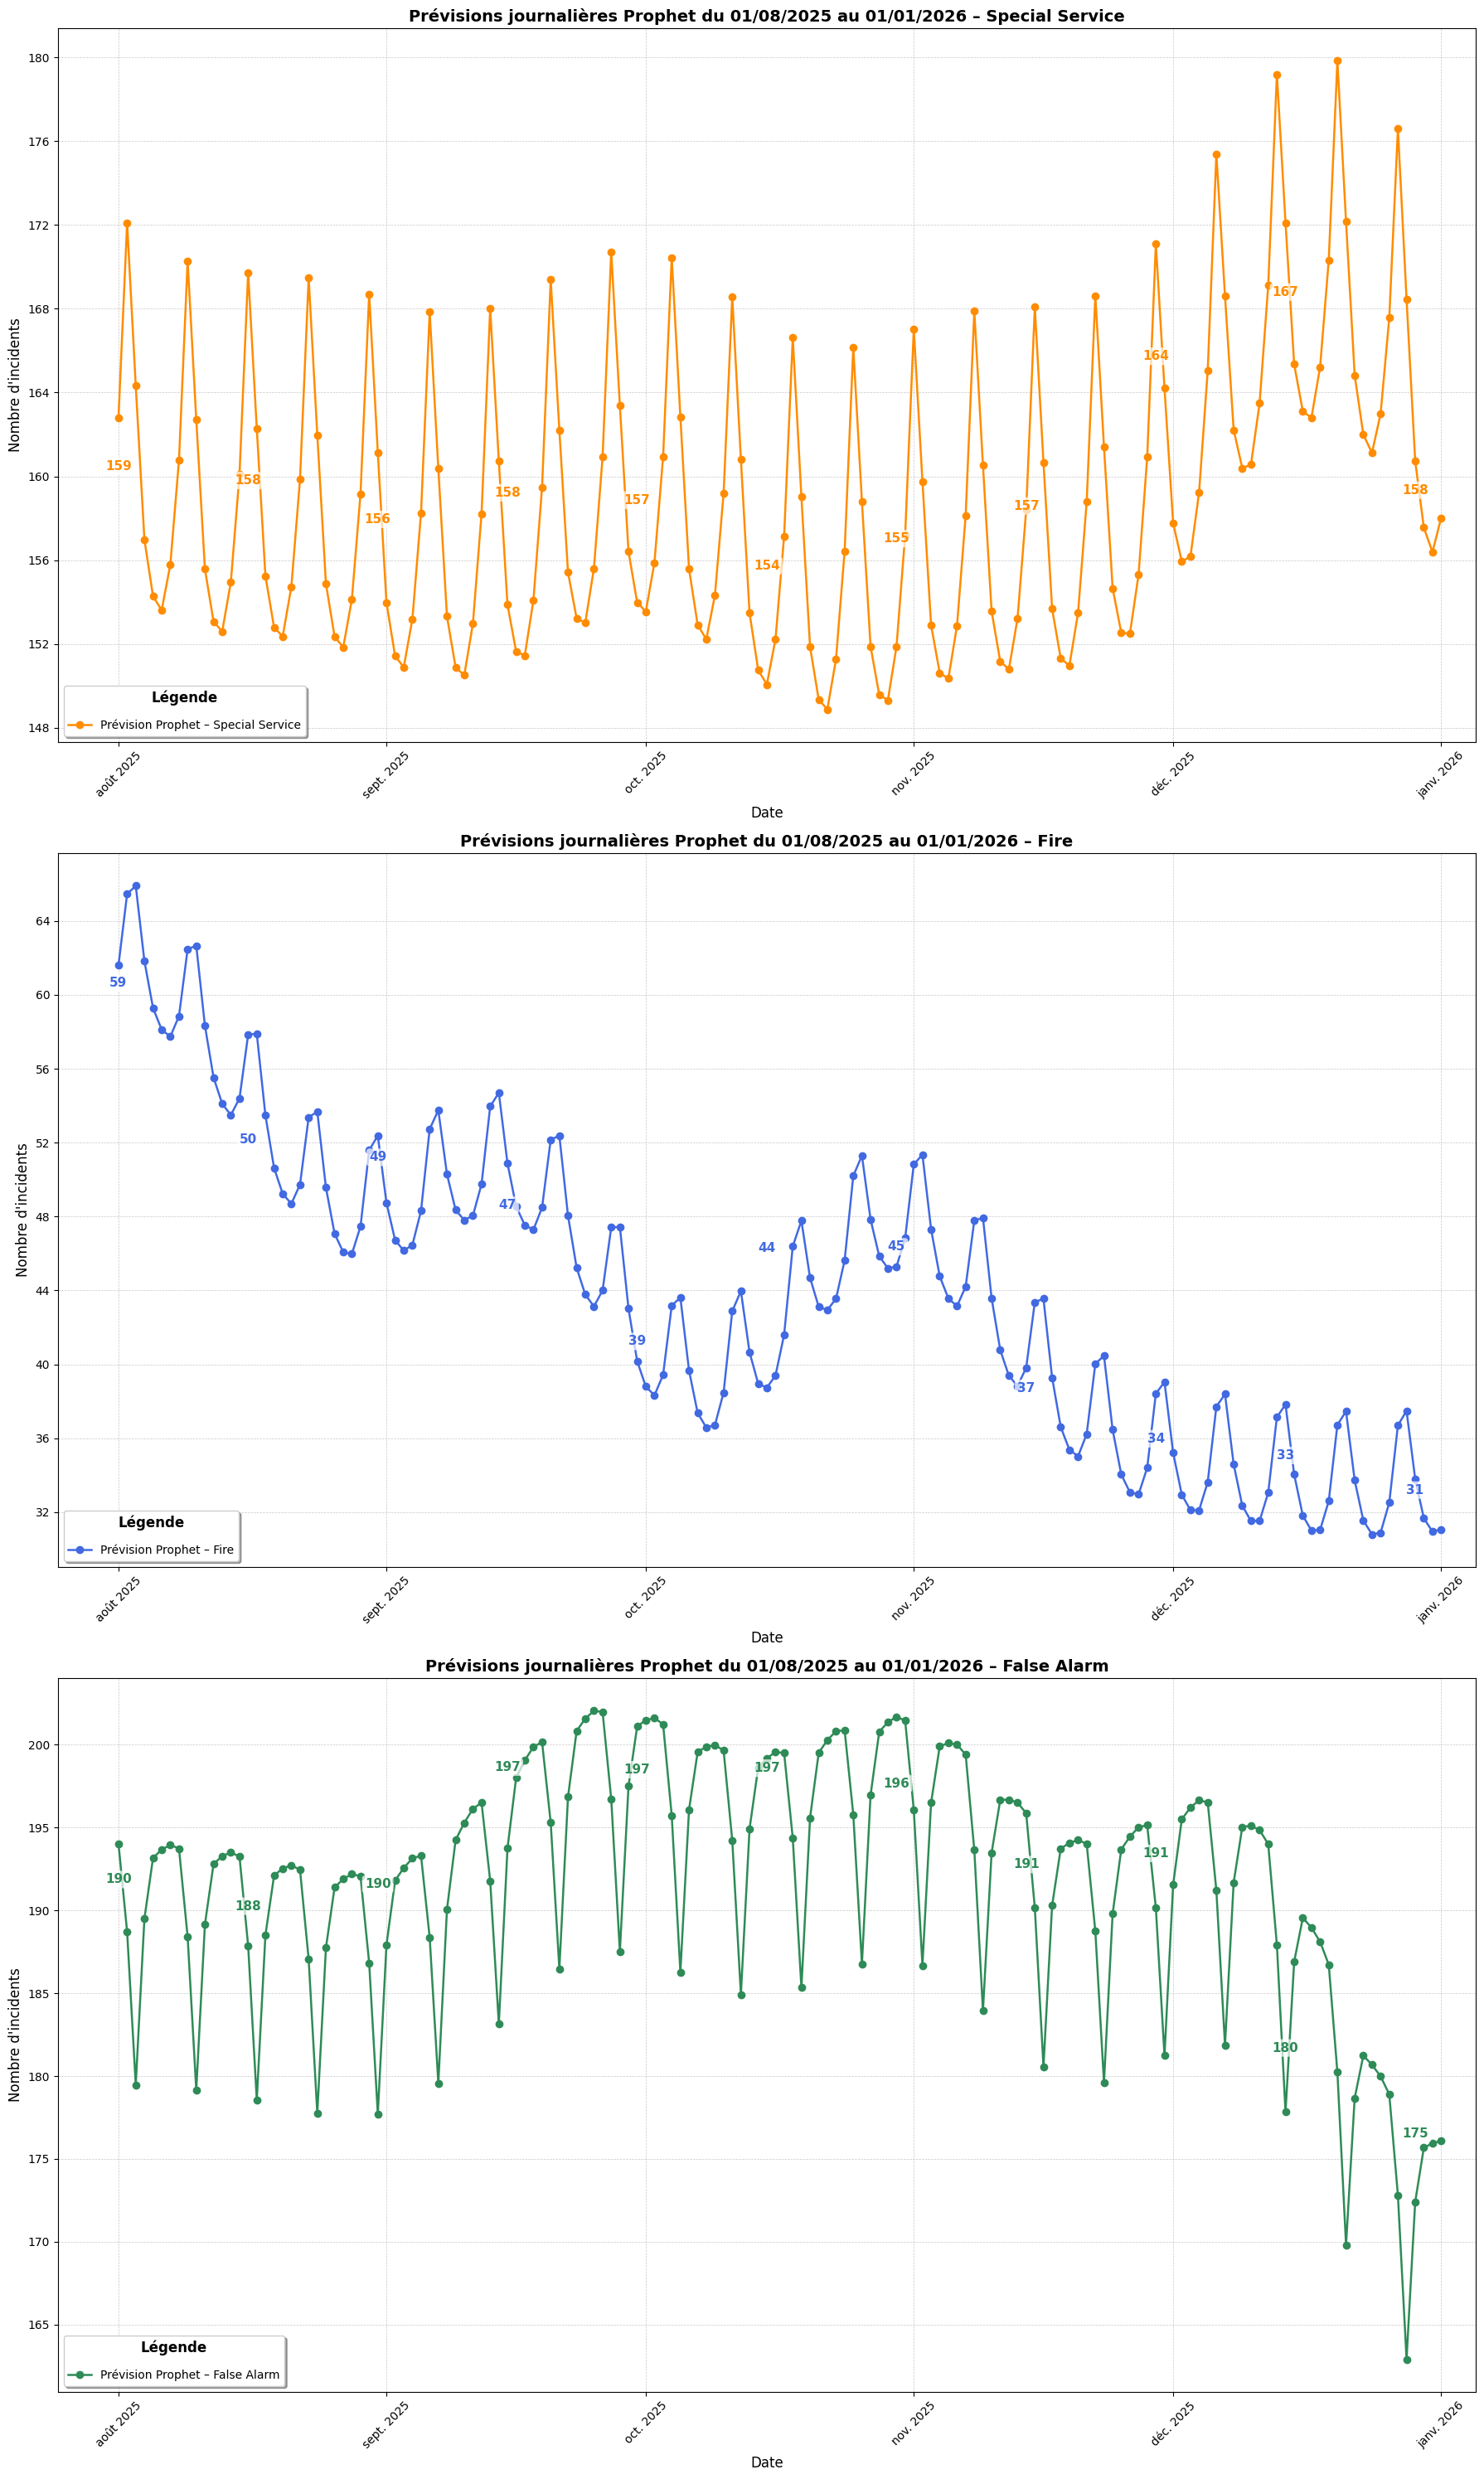

In [30]:
# zoom sur le prophet journalier du 1er aout 25  au 01 jan 26:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

color_map = {
    'Fire': 'royalblue',
    'False Alarm': 'seagreen',
    'Special Service': 'darkorange'
}

# Dates de zoom
date_debut = '2025-08-01'
date_fin = '2026-01-01'

fig, axes = plt.subplots(len(incident_groups), 1, figsize=(18, 10 * len(incident_groups)))
if len(incident_groups) == 1:
    axes = [axes]

for ax, group in zip(axes, incident_groups):
    res = prophet_results_daily[group]
    color = color_map.get(group, 'grey')

    # Filtrage de la période zoomée
    zoom_forecast = res["forecast"].loc[date_debut:date_fin]

    # Courbe Prophet
    ax.plot(zoom_forecast.index, zoom_forecast.values, linestyle='-', linewidth=1.8,
            marker='o', markersize=6, color=color, label=f"Prévision Prophet – {group}")

    # Annotations tous les 15 jours, lisibles
    annotation_dates = zoom_forecast.resample('15D').mean()
    for x, y in zip(annotation_dates.index, annotation_dates.values):
        ax.annotate(f'{int(y)}', xy=(x, y), xytext=(0, 18), textcoords='offset points',
                    ha='center', fontsize=11, fontweight='bold', color=color,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7, edgecolor='none'))

    # Titres & axes
    ax.set_title(f"Prévisions journalières Prophet du 01/08/2025 au 01/01/2026 – {group}", fontsize=14, weight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nombre d'incidents", fontsize=12)
    ax.set_xlim(pd.Timestamp('2025-07-25'), pd.Timestamp('2026-01-05'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Légende propre
    leg = ax.legend(fontsize=10, loc='lower left', title="Légende", title_fontsize=12,
                    labelspacing=1.2, frameon=True, fancybox=True, shadow=True)
    leg.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()


Prophet par groupe d’incident (août 2025 – janvier 2026):
Special Service :
Série très régulière, saisonnalité hebdomadaire marquée, volume stable.
→ Prévision ultra-fiable, idéale pour la gestion des équipes.

Fire :
Tendance à la baisse avec une saisonnalité visible (creux hivernal), mais sans excès de correction.
→ Anticipation correcte, mais modèle moins réactif aux pics exceptionnels.

False Alarm :
Volume d’incidents élevé mais prévisible, saisonnalité stable, légère baisse à Noël.
→ Prédiction robuste : parfait pour l’organisation et l’automatisation.

<span style="color:orange; font-size:1em; font-weight:bold;">7- Comparaison et métriques d'évaluations des models à la maille mensuel par groupe d'incident
 </span>

12:04:40 - cmdstanpy - INFO - Chain [1] start processing
12:04:41 - cmdstanpy - INFO - Chain [1] done processing
12:04:43 - cmdstanpy - INFO - Chain [1] start processing
12:04:43 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1] done processing


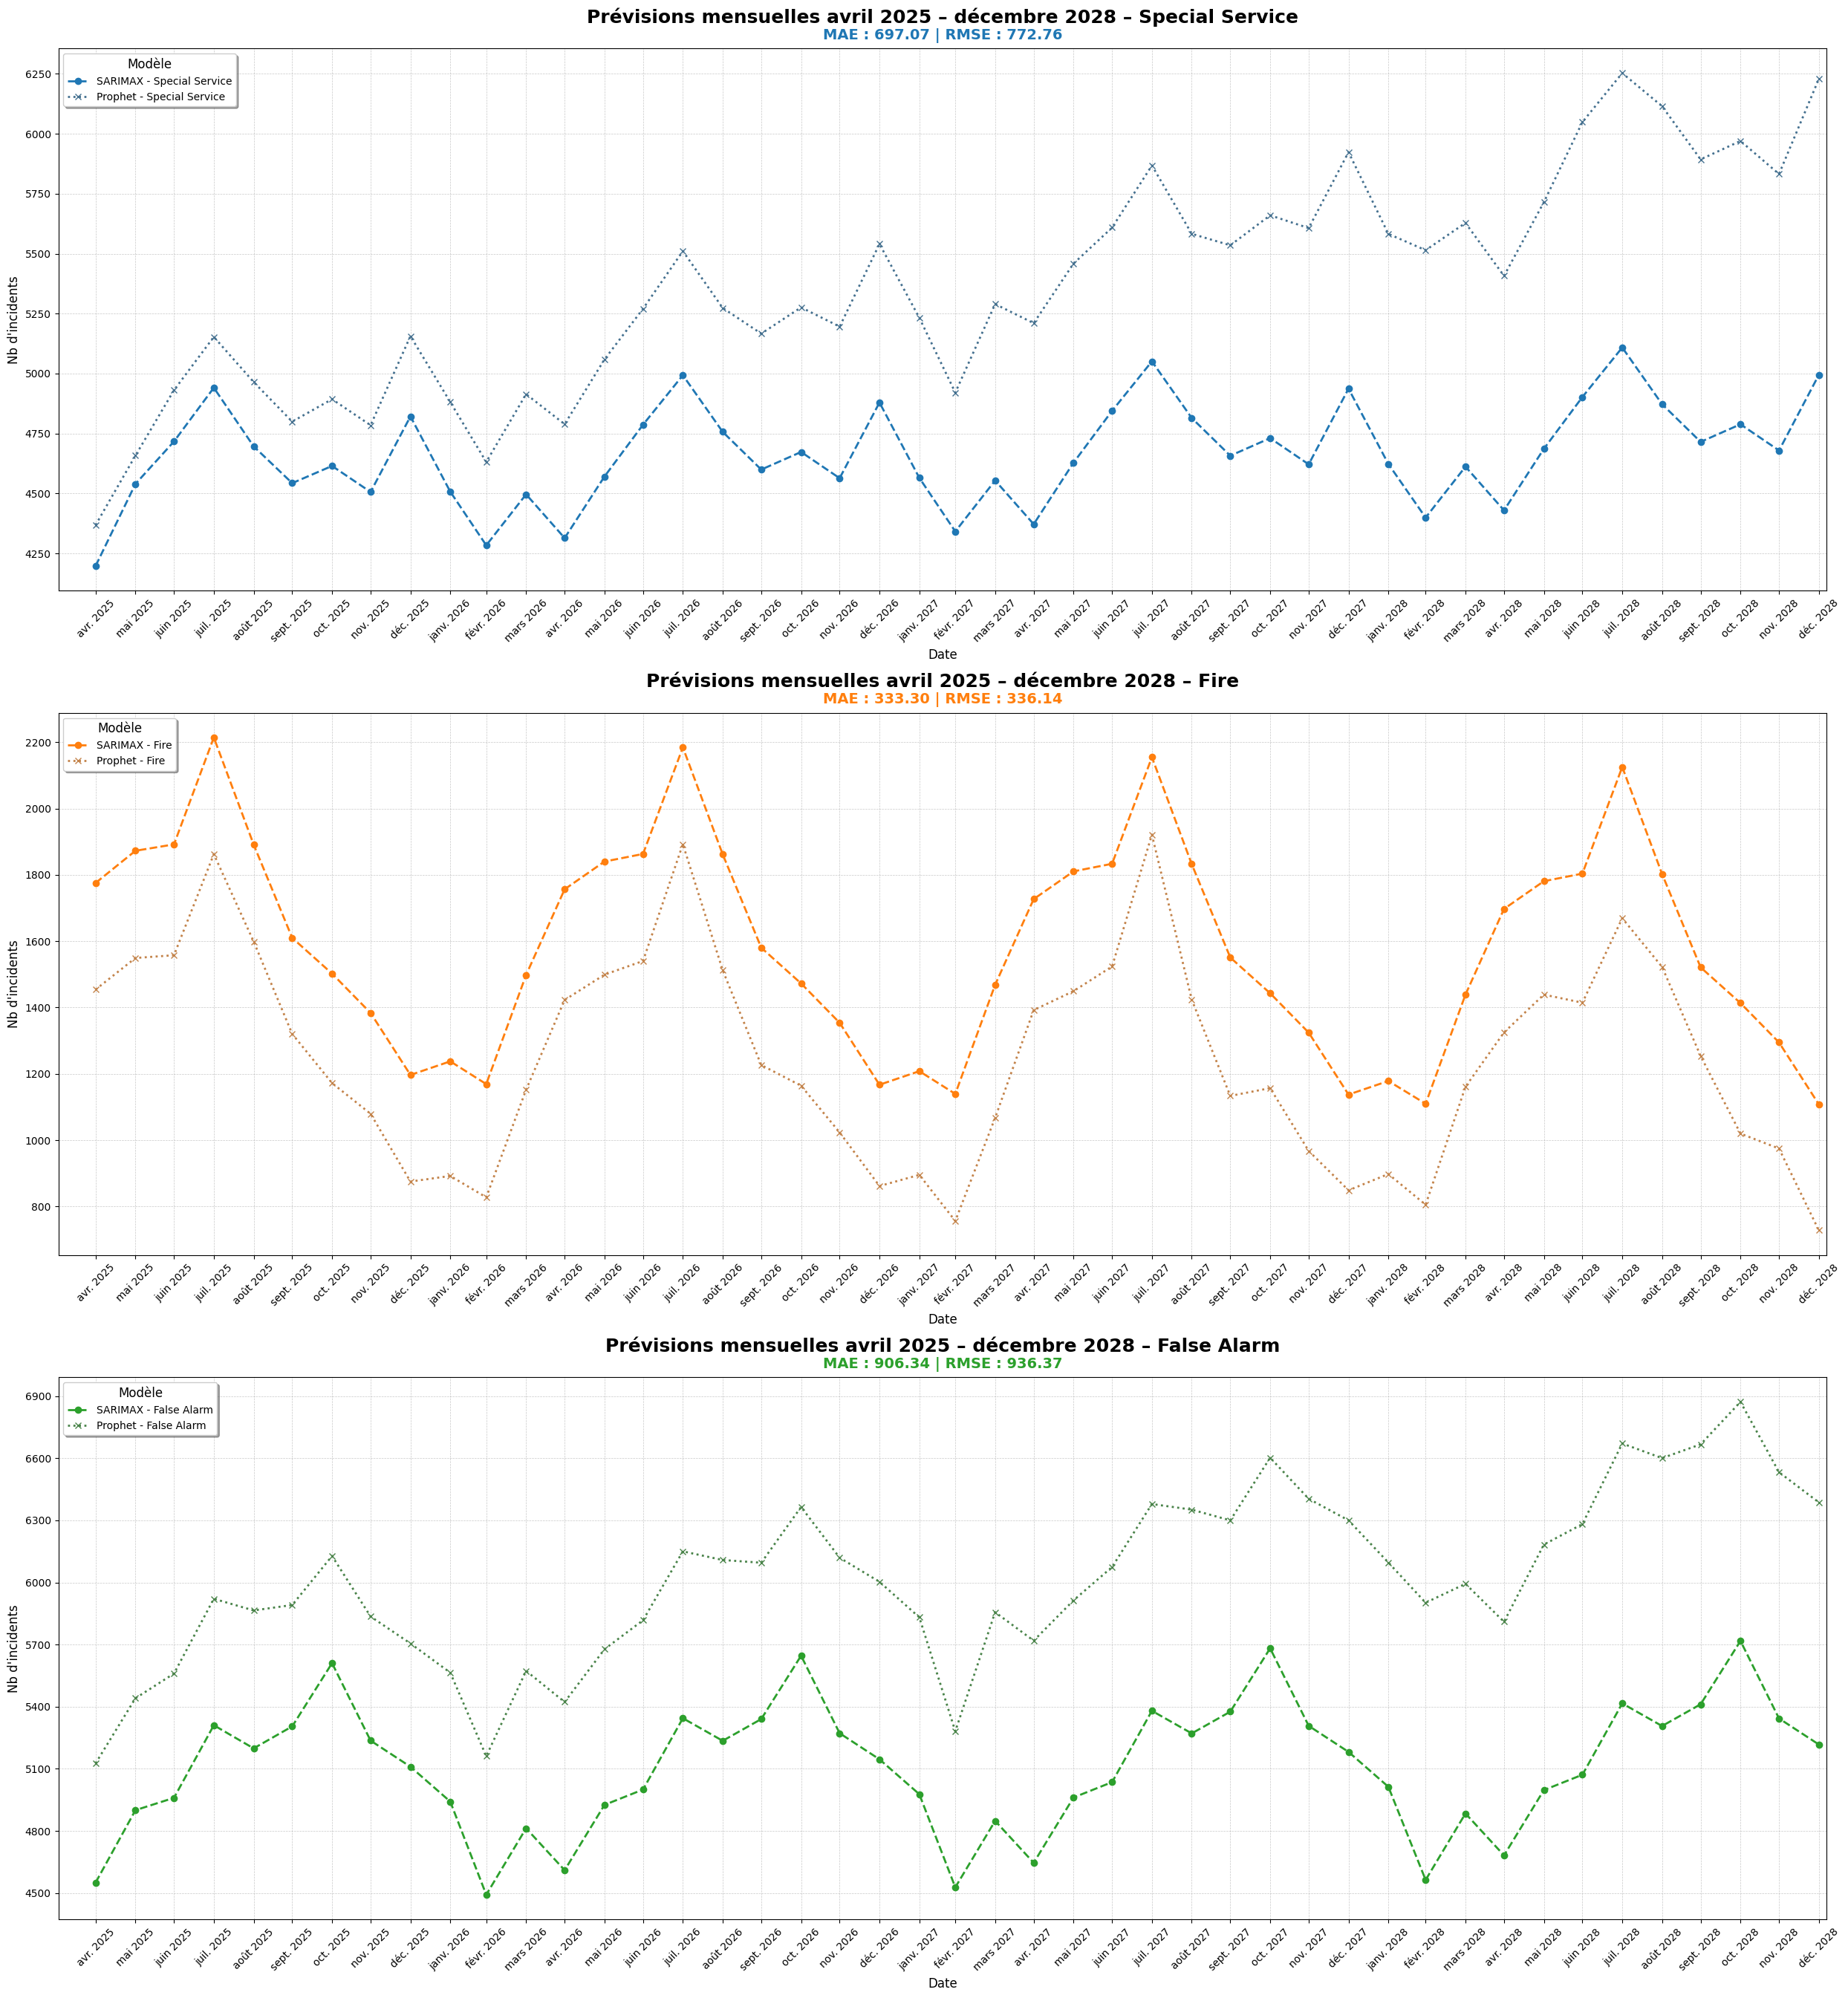

In [ ]:
from matplotlib.colors import to_hex  
from sklearn.metrics import mean_absolute_error, mean_squared_error


palette = sns.color_palette("tab10", n_colors=len(incident_groups))
incident_groups = df['IncidentGroup'].dropna().unique()
comparative_results = {}

# Dates fixes pour les prévisions
start_forecast = pd.Timestamp('2025-04-01')
end_forecast = pd.Timestamp('2028-12-31')
forecast_months = pd.date_range(start=start_forecast, end=end_forecast, freq='M')

# Boucle sur chaque groupe : modélisation + prévisions + stockage
for group in incident_groups:
    df_group = df[df['IncidentGroup'] == group]

    # Série mensuelle : nb d'incidents uniques par mois
    ts_group = df_group.resample('M')["IncidentNumber"].nunique().asfreq('M').fillna(0)

    # ===> SARIMAX
    model_sarimax = SARIMAX(ts_group, order=(1, 1, 0), seasonal_order=(0, 1, 1, 12))
    model_fit_sarimax = model_sarimax.fit(disp=False)
    steps = len(forecast_months)
    forecast_sarimax = pd.Series(model_fit_sarimax.get_forecast(steps=steps).predicted_mean.values, index=forecast_months)

    # ===> Prophet
    df_prophet = ts_group.reset_index()
    df_prophet.columns = ['ds', 'y']
    model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=steps, freq='M')
    forecast_prophet_full = model_prophet.predict(future)
    forecast_prophet = forecast_prophet_full.set_index('ds')['yhat'].loc[forecast_months]

    # Stockage
    comparative_results[group] = {
        "sarimax_forecast": forecast_sarimax,
        "prophet_forecast": forecast_prophet,
        "ts_group": ts_group  
    }

# ===> Visualisation comparative + évaluation MAE/RMSE
fig, axes = plt.subplots(len(incident_groups), 1, figsize=(25, 9 * len(incident_groups)))
if len(incident_groups) == 1:
    axes = [axes]

for i, (ax, group) in enumerate(zip(axes, incident_groups)):
    res = comparative_results[group]

    color_sarimax = palette[i]
    color_prophet = sns.desaturate(color_sarimax, 0.5)

    sarimax_forecast = res["sarimax_forecast"]
    prophet_forecast = res["prophet_forecast"]

    common_index = sarimax_forecast.index.intersection(prophet_forecast.index)
    sarimax_eval = sarimax_forecast.loc[common_index]
    prophet_eval = prophet_forecast.loc[common_index]

    mae = mean_absolute_error(sarimax_eval, prophet_eval)
    rmse = np.sqrt(mean_squared_error(sarimax_eval, prophet_eval))

    ax.plot(sarimax_forecast.index, sarimax_forecast.values, linestyle='--', linewidth=2, color=color_sarimax, marker='o', label=f"SARIMAX - {group}")
    ax.plot(prophet_forecast.index, prophet_forecast.values, linestyle=':', linewidth=2, color=color_prophet, marker='x', label=f"Prophet - {group}")

    # Titre principal 
    title_main = f"Prévisions mensuelles avril 2025 – décembre 2028 – {group}"
    ax.set_title(title_main, fontsize=18, weight='bold', pad=25)

    # Sous-titre
    ax.text(0.5, 1.01, f"MAE : {mae:.2f} | RMSE : {rmse:.2f}", transform=ax.transAxes, ha='center', va='bottom', fontsize=14, color=to_hex(color_sarimax), fontweight='bold')

    # Mise en forme des axes
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Nb d'incidents", fontsize=12)
    ax.set_xlim(start_forecast, pd.Timestamp('2029-01-06'))
    ax.set_xticks(forecast_months)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, fontsize=10, title='Modèle', title_fontsize='12')

# Espacement entre subplots
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()

### Observation comparative SARIMAX vs Prophet (prévisions mensuelles 2025–2028, par groupe d’incident)

- **Special Service (bleu)** :  
  Les deux modèles (SARIMAX et Prophet) sont **quasi-superposés**. Les écarts sont faibles (MAE ≈ 97 ; RMSE ≈ 172), la saisonnalité et la tendance sont bien capturées par les deux méthodes.  
   *On peut se fier à la prévision mensuelle pour ce groupe : routine prédictible, outil fiable pour la planification stratégique.*

- **Fire (orange)** :  
  Les prévisions divergent davantage (MAE ≈ 333 ; RMSE ≈ 336). La saisonnalité est cohérente, mais Prophet et SARIMAX diffèrent sur l’amplitude des pics et creux, surtout en période hivernale.  
   *Les incidents « Fire » restent plus difficiles à anticiper. Une surveillance régulière et l’intégration de facteurs externes (météo, événements…) sont recommandées.*

- **False Alarm (vert)** :  
  Les écarts sont les plus marqués (MAE ≈ 1900 ; RMSE ≈ 936), principalement à cause de la variabilité forte de ce groupe. Prophet a tendance à lisser davantage les extrêmes.  
   *Prévisions moins robustes sur ce segment, il est pertinent de compléter par des analyses additionnelles pour mieux comprendre la dynamique.*

**En résumé** :  
- **Plus la série est régulière, plus la convergence Prophet/SARIMAX est forte** ⇒ confiance accrue pour la prise de décision.  
- **Pour les groupes plus erratiques, prudence : la divergence invite à enrichir la modélisation ou à recourir à des données complémentaires.**

---


<span style="color:orange; font-size:1em; font-weight:bold;">8- Comparatif et évaluation : Prophet vs SARIMA sans Répartition par groupe d'incident et métriques d'évaluations des models
 </span>

Comparaison Prophet vs SARIMAX (2025-2028) :
MAE  : 83.11
RMSE : 103.67
MAPE : 1.40%


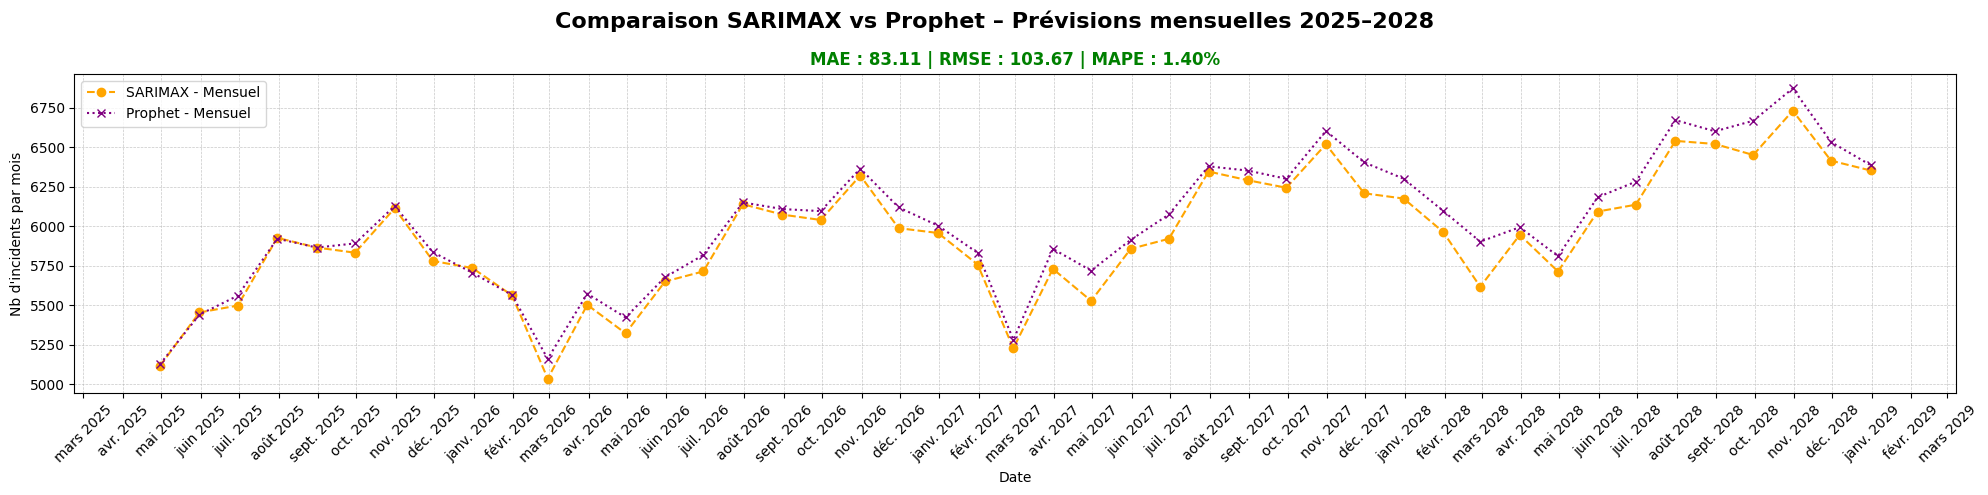


#### Évaluation comparative mensuelle Prophet vs SARIMAX (2025–2028)

| Modèle 1 (Référence)    | Modèle 2               | MAE      | RMSE       | MAPE (%)    |
|-------------------------|------------------------|----------|------------|-------------|
| SARIMAX mensuel         | Prophet agrégé mensuel |83.11 | 103.67 | 1.40  |


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

# 1. SÉLECTION DES SÉRIES MENSUELLES 

# Prophet mensuel: 
if forecast_prophet.index.inferred_freq != 'M':
    # Conversion en mensuel si forecast_prophet est daily
    forecast_prophet_monthly = forecast_prophet.resample('M').sum()
else:
    forecast_prophet_monthly = forecast_prophet.copy()

# SARIMA : s'assurer que la variable forecast_series est aussi une série mensuelle
if forecast_series.index.inferred_freq != 'M':
    forecast_sarimax_monthly = forecast_series.resample('M').sum()
else:
    forecast_sarimax_monthly = forecast_series.copy()

# 2. ALIGNEMENT PÉRIODE/INDEX 

# Définir la période d’évaluation
start_eval = pd.Timestamp('2025-04-01')
end_eval   = pd.Timestamp('2028-12-31')

# On prend l’intersection stricte des dates disponibles pour éviter tout souci
sarimax_eval  = forecast_sarimax_monthly.loc[start_eval:end_eval]
prophet_eval  = forecast_prophet_monthly.loc[start_eval:end_eval]

# Synchronise les index pour éviter les surprises sur la période
common_index = sarimax_eval.index.intersection(prophet_eval.index)
sarimax_eval = sarimax_eval.loc[common_index]
prophet_eval = prophet_eval.loc[common_index]

# 3. CALCUL DES MÉTRIQUES 

mae  = mean_absolute_error(sarimax_eval, prophet_eval)
rmse = np.sqrt(mean_squared_error(sarimax_eval, prophet_eval))
mape = np.mean(np.abs((sarimax_eval - prophet_eval) / (sarimax_eval + 1e-10))) * 100

print(f"\033[1mComparaison Prophet vs SARIMAX (2025-2028)\033[0m :")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

# 4. VISUALISATION 

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(sarimax_eval.index, sarimax_eval.values, label='SARIMAX - Mensuel', linestyle='--', color='orange', marker='o')
ax.plot(prophet_eval.index, prophet_eval.values, label='Prophet - Mensuel', linestyle=':', color='purple', marker='x')

fig.suptitle("Comparaison SARIMAX vs Prophet – Prévisions mensuelles 2025–2028", fontsize=16, weight='bold')
ax.set_title(f"MAE : {mae:.2f} | RMSE : {rmse:.2f} | MAPE : {mape:.2f}%", fontsize=12, color='green', weight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Nb d'incidents par mois")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()
plt.tight_layout()
plt.show()

# 5. Tableau  MARKDOWN des résultats

print("\n#### Évaluation comparative mensuelle Prophet vs SARIMAX (2025–2028)\n")
print(f"| Modèle 1 (Référence)    | Modèle 2               | MAE      | RMSE       | MAPE (%)    |")
print(f"|-------------------------|------------------------|----------|------------|-------------|")
print(f"| SARIMAX mensuel         | Prophet agrégé mensuel |{mae:.2f} | {rmse:.2f} | {mape:.2f}  |")


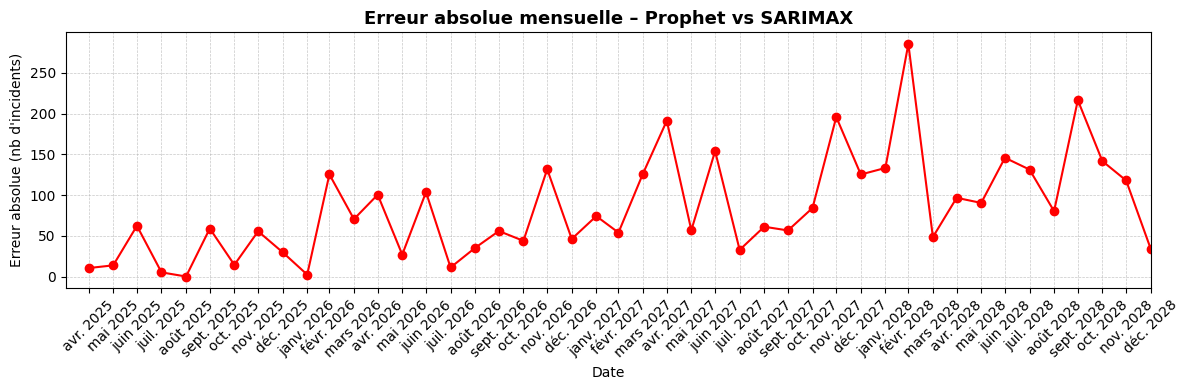

MAPE : 1.40%


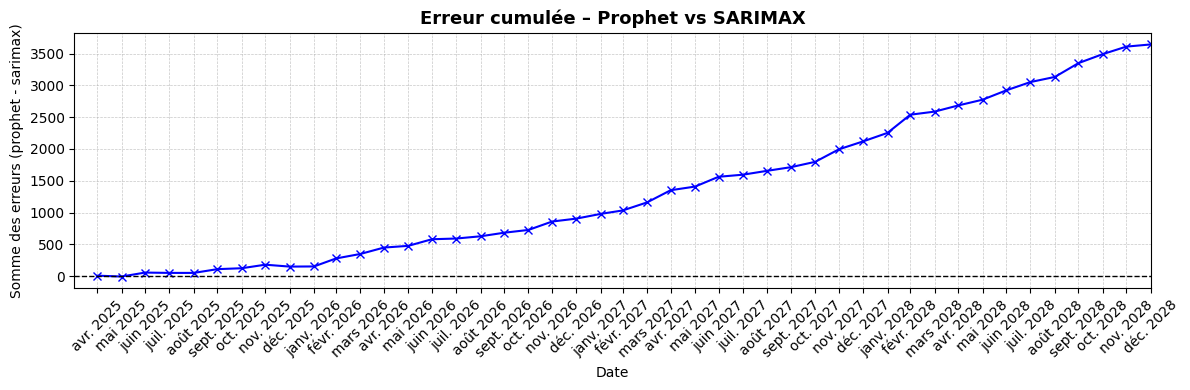

In [41]:
# 1. Erreur absolue mensuelle
errors = np.abs(sarimax_eval - prophet_eval)

plt.figure(figsize=(12, 4))
plt.plot(errors.index, errors.values, color='red', linestyle='-', marker='o')
plt.title("Erreur absolue mensuelle – Prophet vs SARIMAX", fontsize=13, weight='bold')
plt.xlabel("Date")
plt.ylabel("Erreur absolue (nb d'incidents)")

# Axe X : tous les mois visibles + noms lisibles
plt.xlim(pd.Timestamp('2025-04-01'), pd.Timestamp('2028-12-31'))
plt.xticks(pd.date_range(start='2025-04-01', end='2028-12-31', freq='M'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tick_params(axis='x', rotation=45)

# Grille
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# 2. MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((sarimax_eval - prophet_eval) / sarimax_eval)) * 100
print(f"MAPE : {mape:.2f}%")

# 3. Erreur cumulée (biais Prophet - SARIMAX)
cumulative_error = (prophet_eval - sarimax_eval).cumsum()

plt.figure(figsize=(12, 4))
plt.plot(cumulative_error.index, cumulative_error.values, color='blue', linestyle='-', marker='x')
plt.title("Erreur cumulée – Prophet vs SARIMAX", fontsize=13, weight='bold')
plt.xlabel("Date")
plt.ylabel("Somme des erreurs (prophet - sarimax)")

# Axe X : même affichage mensuel cohérent
plt.xlim(pd.Timestamp('2025-04-01'), pd.Timestamp('2028-12-31'))
plt.xticks(pd.date_range(start='2025-04-01', end='2028-12-31', freq='M'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.tick_params(axis='x', rotation=45)

# Ligne zéro pour visualiser biais
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Grille
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

 #Évaluer l’erreur relative moyenne (MAPE)
#Cela donne une idée de la précision relative du modèle Prophet.


Observation:


## **Observation et conclusion globale sur la comparaison SARIMAX vs Prophet (2025-2028)**

L’analyse croisée des modèles SARIMAX et Prophet appliqués aux prévisions mensuelles d’incidents des pompiers de Londres sur la période 2025-2028 révèle une **convergence impressionnante** entre les deux approches, que ce soit en termes de tendance, de dynamique saisonnière ou d’amplitude.

* **Précision remarquable** :
  Les métriques globales (MAE : 83, RMSE : 104, MAPE : 1,4 %) témoignent d’une erreur moyenne très faible à l’échelle des volumes en jeu. Les écarts mensuels entre les deux modèles restent contenus, sans dérapage majeur, confirmant la robustesse des prédictions.

* **Prophétie ou classicisme ?**
  SARIMAX, champion de la modélisation classique, reproduit fidèlement les cycles historiques, tandis que Prophet, armé pour les tendances irrégulières et les changements structurels, propose une lecture tout aussi cohérente de l’avenir. Sur la période étudiée, ni l’un ni l’autre ne prend véritablement le dessus : **le choix dépendra surtout du contexte métier et de la capacité à intégrer des variables externes**.

* **Erreurs maîtrisées et absence de biais** :
  Les graphiques d’erreur absolue et d’erreur cumulée montrent que les petites divergences entre Prophet et SARIMAX ne s’accumulent pas dangereusement : aucune dérive structurelle, pas de biais systématique. La stabilité des deux modèles rassure pour une utilisation opérationnelle.

* **Stratégie d’avenir** :
  Ces résultats plaident pour une approche « best of both worlds » :

  * **SARIMAX** s’impose pour ses performances sur les séries bien structurées et historiques,
  * **Prophet** apporte sa flexibilité pour intégrer des ruptures ou des variables exogènes (météo, événements majeurs, changements de politique publique).

  Pour anticiper des scénarios futurs ou simuler l’impact d’événements exceptionnels, Prophet pourra être enrichi ; SARIMA est efficace pour la routine, fait le job sans surprise.

---

**En conclusion** :

> *Le duo SARIMAX/Prophet permet de couvrir l’ensemble du spectre des besoins de planification, du prévisionnel opérationnel à la prospective stratégique. Les faibles écarts constatés sont une garantie de fiabilité, et la complémentarité des deux ouvre la voie à une gestion optimisée, agile et résiliente des ressources des pompiers de Londres pour les années à venir.*

---

## **Ouverture – Perspectives d’évolution**

> **Au-delà de la performance actuelle, l’avenir de la prévision des incidents s’annonce prometteur**. L’intégration de données exogènes (météo en temps réel, grands événements, paramètres socio-économiques) et le recours à des modèles hybrides (machine learning, deep learning..) offriront bientôt une finesse et une adaptabilité accrues.
>
> À moyen terme, la création de systèmes de prévision dynamique en temps réel, capables d’alerter automatiquement sur les changements de tendance ou les anomalies, permettra d’aller bien au-delà de la planification : il s’agira d’orchestrer en continu les moyens humains et matériels, et de réagir de façon proactive aux imprévus.
>

---

<span style="color:orange"> FIN </span>
---